In [3]:
import numpy as np
from matplotlib import pyplot as plt
from rbergomi.rbergomi import rBergomi
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

import QuantLib as ql

from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException
import sklearn.utils
import logging

from scipy.signal import savgol_filter

logging.basicConfig(format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO)

%matplotlib inline

In [6]:
import helpers

In [3]:
#load any aribitrary set
K_T = pd.read_csv('labeled_data_all.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'labeled_data_all.csv'

In [31]:
#or us real data, the data is pre-processed and only liquid quotes are contained
df1 = helpers.load_month(2023,1,'SPX')
df2 = helpers.load_month(2023,2,'SPX')
df3 = helpers.load_month(2023,3,'SPX')
df5 = helpers.load_year(2022,'SPX')

df6 = helpers.load_year(2021,'SPX')
df6 = helpers.load_year(2020,'SPX')
df7 = helpers.load_year(2019,'SPX')

In [32]:
#if no data loaded  via csv, merge the loaded data
K_T_all = pd.concat([df1,df2,df3,df5,df6,df7])

In [33]:
K_T_all.head()

,[QUOTE_DATE],[UNDERLYING_LAST],[EXPIRE_DATE],[DTE],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],...,[P_BID],[P_ASK],[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME]
[QUOTE_READTIME],,,,,,,,,,,,,,,,,,,,,
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00211,0.00014,2.92769,-0.03449,0.06761,0.31948,...,5.1,6.7,6.14,-1.00000,0.0,-26.10045,0.00000,0.0000,0.002570,2638.000000
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00183,0.00014,2.03693,-0.02576,0.04657,0.31912,...,4.0,9.5,10.45,-0.97158,0.0,0.00000,-108.45324,-0.0774,0.002600,3144.000000
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00217,0.00016,1.41177,-0.02494,0.03242,0.31939,...,10.5,14.5,18.65,-0.97163,0.0,0.00000,-108.45209,-0.0770,0.002670,2298.000000
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00236,0.00010,0.97818,-0.02507,0.02208,0.32008,...,19.1,21.8,23.3,-1.00000,0.0,-176.09987,0.00000,0.0000,0.002590,2155.000000
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00153,0.00010,0.67631,-0.02501,0.01536,0.31959,...,24.3,26.7,35.07,-1.00000,0.0,-226.10041,0.00000,0.0000,0.002470,651.000000


In [34]:
K_T_all.shape

(4426727, 26)

2023-06-03 16:15:09,812 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-06-03 16:15:09,904 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


([<matplotlib.axis.XTick at 0x1d66ec00a10>,
 [Text(0, 0, ' 2019-01-02'),
  Text(90, 0, ' 2019-05-15'),
  Text(180, 0, ' 2019-09-26'),
  Text(270, 0, ' 2020-02-05'),
  Text(360, 0, ' 2020-06-15'),
  Text(450, 0, ' 2020-10-22'),
  Text(540, 0, ' 2022-03-03'),
  Text(630, 0, ' 2022-07-12'),
  Text(720, 0, ' 2022-11-15'),
  Text(810, 0, ' 2023-03-28')])

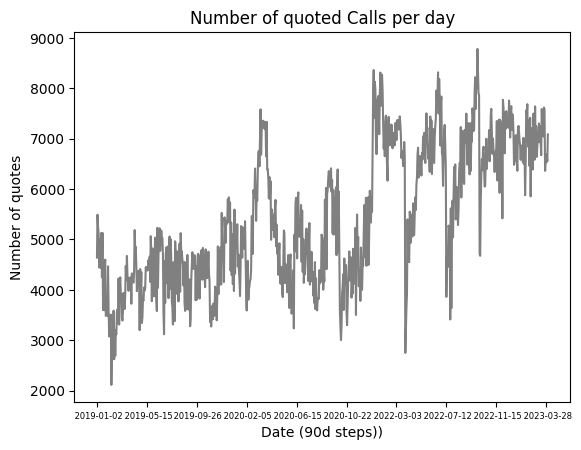

In [35]:
#count oentries for each day
#pivot with quote date as index and values count of lines
quote_number = K_T_all.pivot_table(index=' [QUOTE_DATE]', values=' [DTE]', aggfunc='count')
plt.plot(quote_number, color='grey')
plt.title('Number of quoted Calls per day')
plt.xlabel('Date (90d steps))')
plt.ylabel('Number of quotes')
#set vector dates as xticks
plt.xticks(np.arange(0, len(quote_number), 90), size=6)


In [36]:
#mean quotes per day
quote_number.mean()

 [DTE]    5438.239558
dtype: float64

In [37]:
#arrange all dates from 2023-01-04	 to 2023-03-17 but only every 30th day and make in MMM-yy format
dates = pd.date_range(start='2019-01-04', end='2023-03-31', freq='30D').strftime('%b-%y').tolist()
dates

['Jan-19',
 'Feb-19',
 'Mar-19',
 'Apr-19',
 'May-19',
 'Jun-19',
 'Jul-19',
 'Aug-19',
 'Sep-19',
 'Oct-19',
 'Oct-19',
 'Nov-19',
 'Dec-19',
 'Jan-20',
 'Feb-20',
 'Mar-20',
 'Apr-20',
 'May-20',
 'Jun-20',
 'Jul-20',
 'Aug-20',
 'Sep-20',
 'Oct-20',
 'Nov-20',
 'Dec-20',
 'Jan-21',
 'Feb-21',
 'Mar-21',
 'Apr-21',
 'May-21',
 'Jun-21',
 'Jul-21',
 'Aug-21',
 'Sep-21',
 'Oct-21',
 'Nov-21',
 'Dec-21',
 'Jan-22',
 'Feb-22',
 'Mar-22',
 'Apr-22',
 'May-22',
 'Jun-22',
 'Jul-22',
 'Aug-22',
 'Sep-22',
 'Oct-22',
 'Nov-22',
 'Dec-22',
 'Jan-23',
 'Feb-23',
 'Mar-23']

In [38]:
#set every 30st index visible and all the rest to "" in quote_number.index
quote_number_index = np.where(quote_number.index % 30 == 0, quote_number.index, "")

TypeError: not all arguments converted during string formatting

In [40]:
#histogram of the moneyness
K_T_all['Log Moneyness'] = np.log( K_T_all[' [STRIKE]'] / K_T_all[' [UNDERLYING_LAST]'])

In [ ]:
K_T_all.head()

,[QUOTE_DATE],[UNDERLYING_LAST],[EXPIRE_DATE],[DTE],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],...,[P_ASK],[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],Moneyness
[QUOTE_READTIME],,,,,,,,,,,,,,,,,,,,,
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00211,0.00014,2.92769,-0.03449,0.06761,0.31948,...,6.7,6.14,-1.00000,0.0,-26.10045,0.00000,0.0000,0.002570,2638.000000,1.000418
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00183,0.00014,2.03693,-0.02576,0.04657,0.31912,...,9.5,10.45,-0.97158,0.0,0.00000,-108.45324,-0.0774,0.002600,3144.000000,1.001715
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00217,0.00016,1.41177,-0.02494,0.03242,0.31939,...,14.5,18.65,-0.97163,0.0,0.00000,-108.45209,-0.0770,0.002670,2298.000000,1.003013
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00236,0.00010,0.97818,-0.02507,0.02208,0.32008,...,21.8,23.3,-1.00000,0.0,-176.09987,0.00000,0.0000,0.002590,2155.000000,1.004310
2023-01-04 16:00:00,2023-01-04,3853.39,2023-01-04,0.0,0.00153,0.00010,0.67631,-0.02501,0.01536,0.31959,...,26.7,35.07,-1.00000,0.0,-226.10041,0.00000,0.0000,0.002470,651.000000,1.005608


In [ ]:
bid = np.array(K_T_all[' [C_BID]'])
ask = np.array(K_T_all[' [C_ASK]'])

In [ ]:
#convert ' ' to nan
bid[bid == ' '] = np.nan
ask[ask == ' '] = np.nan
#convert to float
bid = bid.astype(float)
ask = ask.astype(float)
b_a = pd.Series((ask - bid) / bid)
K_T_all['B/O spread'] = np.array(b_a)

C:\Users\caspa\AppData\Local\Temp\ipykernel_31516\346656941.py:7: RuntimeWarning: divide by zero encountered in divide
  b_a = pd.Series((ask - bid) / bid)


In [ ]:
print(bid[10000])
print(ask[10000])
print(b_a[10000])

0.7
0.85
0.21428571428571433


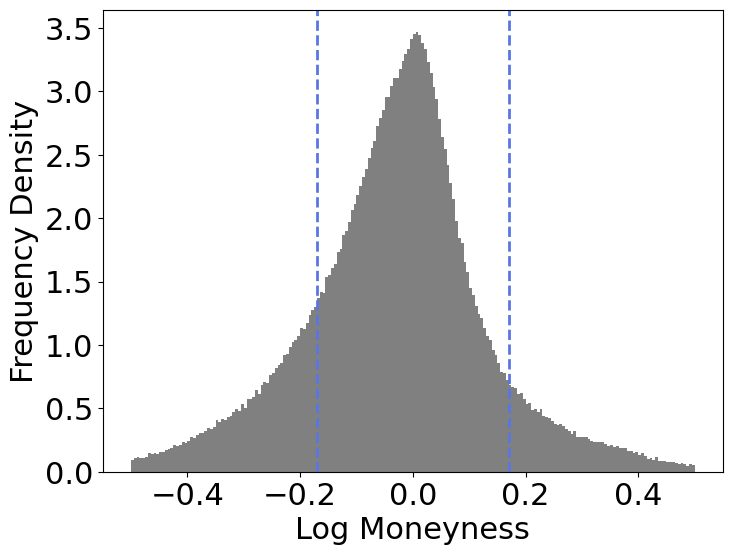

In [56]:
#histogram of the moneyness
plt.figure(figsize=(8,6))
K_T_all['Log Moneyness'].plot(kind='hist', bins=200, range=(-0.5,0.5), density=True, color='grey')
#set x-axis label
plt.xlabel('Log Moneyness', size=22)
#set y-axis label
plt.ylabel('Frequency Density', size=22)
# set axis size
plt.xticks(size=22)
plt.yticks(size=22)
plt.axvline(x=-0.17, color='#5977E3', linestyle='--', linewidth=2)
plt.axvline(x=0.17, color='#5977E3', linestyle='--', linewidth=2)

(array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
        0.02  , 0.0225]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.0025, '0.00'),
  Text(0, 0.005, '0.01'),
  Text(0, 0.0075, '0.01'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.0125, '0.01'),
  Text(0, 0.015, '0.01'),
  Text(0, 0.0175, '0.02'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.0225, '0.02')])

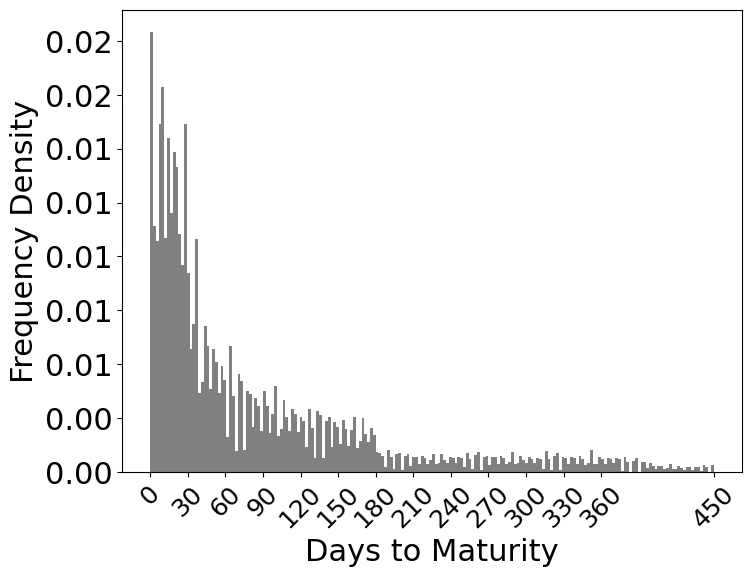

In [63]:
#make a barplot showing the frequency of DTE, show range from 0 to 367 days and make it relative frequency
K_T_all[' [DTE]'].plot(kind='hist', bins=200, range=(0,450), density=True, color='grey', figsize=(8,6))
#set x-axis label
plt.xlabel('Days to Maturity', size=22)
#set y-axis label
lbls = np.array([0,30,60,90,120,150,180,210,240,270,300,330,360,450])
plt.xticks(lbls, size=18, rotation=45)
#only 2 digits on y-axis
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.ylabel('Frequency Density', size=22)
plt.yticks(size=22)

In [29]:
#filter outliers
K_T_all_copy = K_T_all[K_T_all['B/O spread'] < 40]
#filter days
K_T_all_copy = K_T_all_copy[K_T_all_copy[' [DTE]'] < 450]

Text(0, 0.5, '% Bid/Ask spread')

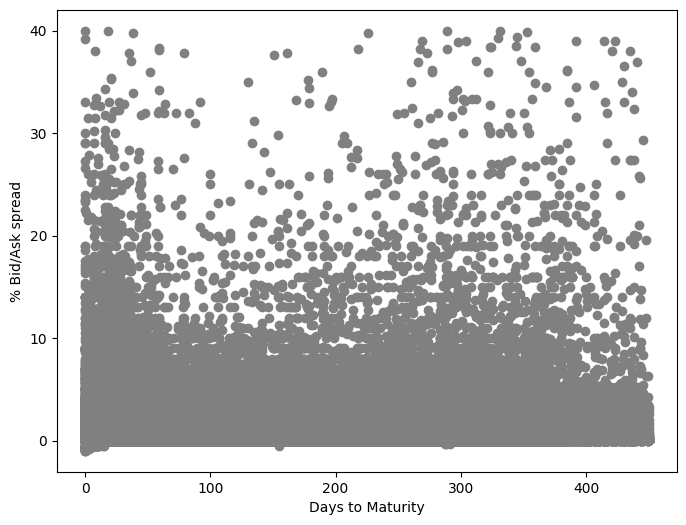

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(K_T_all_copy[' [DTE]'], K_T_all_copy['B/O spread'],color='grey')
plt.xlabel('Days to Maturity')
plt.ylabel('% Bid/Ask spread')


In [6]:
def rBergomi_pricer(H, eta, rho, v0, tau, K, S0, MC_samples=60000):
#pricer taken from https://github.com/ryanmccrickerd/rough_bergomi implementation
    """Computes European Call price under rBergomi dynamics with MC sampling.
    
    Parameters:
    -----------
        H: Hurst parameter
        eta: volatility of variance
        rho: correlation between stock and vol
        v0: spot variance
        tau: time to maturity in years (365 trading days per year)
        K: strike price
    """
    try:
        rB = rBergomi(n=365, N=MC_samples, T=tau, a=H-0.5)
        dW1, dW2 = rB.dW1(), rB.dW2()
        Y = rB.Y(dW1)
        dB = rB.dB(dW1, dW2, rho)
        xi = v0
        V = rB.V(Y, xi, eta)
        S = rB.S(V, dB)
        ST = S[:, -1]
        price = np.mean(np.maximum(ST-K, 0))
    except:
        return np.nan, np.nan
    
    # check numerical stability
    if price <= 0 or price + K < S0:
        iv = np.nan
        logging.debug("NumStabProblem: Price {}. Intrinsic {}. Time {}. Strike {}.".format(price, S0-K, tau, K))
    else:
        logging.debug("Success: Price {} > intrinsic {}".format(price, S0-K))
        iv = implied_volatility(price, S0, K, tau, 0, 'c')
    return price, iv

In [7]:
# PARAMETERS
n_samples = K_T.shape[0]

# Market params
S0 = 1.

In [8]:
from scipy.stats import truncnorm

def param_generator(H_generator=truncnorm(-1.2, 8.6, 0.07, 0.05), 
                    eta_generator=truncnorm(-3, 3, 2.5, 0.5), 
                    rho_generator=truncnorm(-0.25, 2.25, -0.95, 0.2), 
                    v0_generator=truncnorm(-2.5, 7, 0.3, 0.3)):#adjusted
    rslt = {
        'H': H_generator.rvs(),
        'eta': eta_generator.rvs(),
        'rho': rho_generator.rvs(),
        'v0': v0_generator.rvs() ** 2
    }
    return rslt

In [9]:
def generate_rBergomi_sample(K, T, param_generator, S0=1.0):
    """ Generates a rBergomi sample with random parameters
    """
    counter = 0
    while counter < 1:
        params = param_generator()
        H, eta, rho, v0 = params['H'], params['eta'], params['rho'], params['v0']
        _, iv = rBergomi_pricer(H, eta, rho, v0, T, K, S0)
        if np.isnan(iv):
            counter += 1
        else:
            break
    else:
        logging.warning("Tried 10 times, none valid sample obtained.")
    sample = {
        'H': H,
        'eta': eta,
        'rho': rho,
        'v0': v0,
        'iv': iv
    }
    return sample

In [6]:
import gc
gc.collect()

483

In [11]:
i = 0
while 180000+i*1000 <= 240000:
  j = 180000+i*1000
  K_T2 = K_T[j:j+1000]
  data_nn2 = K_T2.merge(K_T2.progress_apply(
    lambda row: pd.Series(generate_rBergomi_sample(row['Moneyness'], row['Time to Maturity (years)'], param_generator, S0)), 
    axis=1), left_index=True, right_index=True)
  data_nn2.dropna(inplace=True)
  data_nn2.to_csv('c{}.csv'.format(j), index=False)
  i = i+1

 11%|█▏        | 113/1000 [04:17<30:47,  2.08s/it]

In [ ]:
data_nn = K_T.merge(K_T.progress_apply(
    lambda row: pd.Series(generate_rBergomi_sample(row['Moneyness'], row['Time to Maturity (years)'], param_generator, S0)), 
    axis=1), left_index=True, right_index=True)

In [ ]:
data_nn = data_nn.dropna()

In [11]:
#save the file

Data Merger

In [14]:
#load all csv files from current directory and concatenate them
import glob
import os
import pandas as pd
os.chdir('c:\\Users\\caspa\\OneDrive\\Dokumente\\UNI\\THESIS\\code\\my\\datav3')
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#remove cols v0_x, H_x, eta_x, rho_x, iv_x
combined_csv = combined_csv.drop(['v0_x', 'H_x', 'eta_x', 'rho_x', 'iv_x'], axis=1)
#rename cols without _y
combined_csv = combined_csv.rename(columns={'v0_y': 'v0', 'H_y': 'H', 'eta_y': 'eta', 'rho_y': 'rho', 'iv_y': 'iv'})


#save to csv
combined_csv.to_csv( "labeled_data_all.csv", index=False, encoding='utf-8-sig')

In [15]:
combined_csv.shape

(1112371, 7)

(array([30051., 23034., 26676., 25773., 28473., 29497., 32331., 33288.,
        34878., 35613., 36913., 36530., 44191., 41636., 38497., 42267.,
        38316., 42735., 38352., 42733., 38256., 41569., 34316., 38046.,
        31582., 40435., 35076., 30613., 30762., 28239., 30604., 25777.,
        24505., 23493., 25521., 21462., 21082., 23531., 21639., 18050.,
        14880., 16211., 15344., 13632., 11318., 11083., 15276.,  9112.,
         8285.,  8259.]),
 array([0.8511008 , 0.85706437, 0.86302795, 0.86899152, 0.8749551 ,
        0.88091867, 0.88688225, 0.89284582, 0.8988094 , 0.90477297,
        0.91073655, 0.91670012, 0.9226637 , 0.92862727, 0.93459085,
        0.94055442, 0.946518  , 0.95248158, 0.95844515, 0.96440873,
        0.9703723 , 0.97633588, 0.98229945, 0.98826303, 0.9942266 ,
        1.00019018, 1.00615375, 1.01211733, 1.0180809 , 1.02404448,
        1.03000805, 1.03597163, 1.0419352 , 1.04789878, 1.05386235,
        1.05982593, 1.0657895 , 1.07175308, 1.07771666, 1.08368023

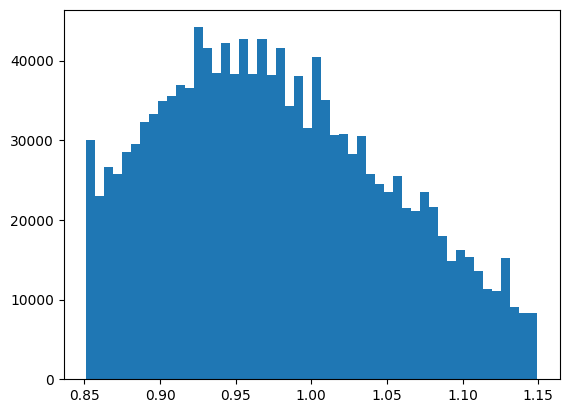

In [7]:
#histogram of combined_csv.iloc[:,0]
import matplotlib.pyplot as plt
plt.hist(combined_csv.iloc[:,0], bins=50)

In [8]:
combined_csv.head()

,Moneyness,Time to Maturity (years),H,eta,rho,v0,iv,H,eta,rho,v0,iv
0,1.056539,0.059524,0.119143,3.511037,-0.891144,0.277144,0.313920,NaN,NaN,NaN,NaN,NaN
1,1.132845,0.416508,0.035381,1.964658,-0.974987,0.077727,0.214753,NaN,NaN,NaN,NaN,NaN
2,0.967320,0.115079,0.068134,1.616390,-0.672798,0.058518,0.242484,NaN,NaN,NaN,NaN,NaN
3,0.990799,0.055556,0.027585,2.936745,-0.981633,0.731216,0.627406,NaN,NaN,NaN,NaN,NaN
4,0.954407,0.087302,0.036522,1.838230,-0.852812,0.581457,0.708628,NaN,NaN,NaN,NaN,NaN


Heston Data Generator

In [4]:
#load Moneyness-Time to maturity combinations
K_T = pd.read_csv("heston_data.csv", index_col=0)

In [5]:
K_T.shape

(1048575, 8)

In [6]:

K_T = K_T.iloc[:,0:2]

In [7]:
K_T.shape

(1048575, 2)

In [8]:
#make empty cols for all variables and output
columns = ['lambda', 'vbar', 'eta', 'rho', 'v0','rfr', 'iv']
data_nn = pd.DataFrame(index=K_T.index, columns=columns)
data_nn = pd.concat([K_T, data_nn], axis=1)

In [9]:
data_nn.shape

(1048575, 9)

In [10]:
data_nn.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0,rfr,iv
index,,,,,,,,,
NaN,1.056539,0.059524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,1.132845,0.416508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,0.967320,0.115079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,0.990799,0.055556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,0.954407,0.087302,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#generate unifomr distributed random numbers for each variable
n_samples = data_nn.shape[0]

# Heston parameter, bounds by Moodley (2005)
lambd_bounds = [0, 10]
vbar_bounds = [0, 1]
eta_bounds = [0, 5]
rho_bounds = [-1, 0]
v0_bounds = [0, 1]

rfr_bounds = [0.0, 0.0525]      #realistic bounds for 3m LIBOR 2019-2023

# Market params, as we use moneyness S0=1
S0 = 1

q = 0

In [12]:
#fill with random numbers from selected distribution
data_nn['lambda'] = np.random.uniform(lambd_bounds[0], lambd_bounds[1], n_samples)
data_nn['vbar'] = np.random.uniform(vbar_bounds[0], vbar_bounds[1], n_samples)
data_nn['eta'] = np.random.uniform(eta_bounds[0], eta_bounds[1], n_samples)
data_nn['rho'] = np.random.uniform(rho_bounds[0], rho_bounds[1], n_samples)
data_nn['v0'] = np.random.uniform(v0_bounds[0], v0_bounds[1], n_samples)
data_nn['rfr'] = np.random.uniform(rfr_bounds[0], rfr_bounds[1], n_samples)

In [13]:
from utils import *

In [15]:
#testing pricer
heston_pricer(data_nn['lambda'].iloc[0], data_nn['vbar'].iloc[0], data_nn['eta'].iloc[0], data_nn['rho'].iloc[0], data_nn['v0'].iloc[0], 0.001, 0, 1, 1,1)[0]

0.24754145860960847

In [16]:
for i in range(n_samples):
    if i%50000 == 0:
        print(i/n_samples)
    try:
        iv = heston_pricer(data_nn['lambda'].iloc[i], data_nn['vbar'].iloc[i], data_nn['eta'].iloc[i], data_nn['rho'].iloc[i], data_nn['v0'].iloc[i], data_nn['rfr'].iloc[i], 0,  data_nn['Time to Maturity (years)'].iloc[i], S0, data_nn['Moneyness'].iloc[i])[1]
    except:
        print("failed")
        iv = np.nan
    data_nn['iv'].iloc[i] = iv

0.0


C:\Users\caspa\AppData\Local\Temp\ipykernel_12396\3864809989.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nn['iv'].iloc[i] = iv
2023-05-21 13:05:32,506 - INFO - RuntimeError: Intrinsic 0.14772527199999996. Time 0.003968254. Strike 0.852274728.


failed
failed
failed


2023-05-21 13:05:43,901 - INFO - RuntimeError: Intrinsic -0.0283645480000001. Time 0.46031746. Strike 1.028364548.
2023-05-21 13:05:47,247 - INFO - RuntimeError: Intrinsic -0.1445838290000001. Time 0.404761905. Strike 1.144583829.


failed
failed
failed
failed
failed


2023-05-21 13:06:03,046 - INFO - RuntimeError: Intrinsic 0.015070940999999949. Time 0.202380952. Strike 0.984929059.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:06:38,195 - INFO - RuntimeError: Intrinsic 0.032679923. Time 0.388730159. Strike 0.967320077.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:07:08,917 - INFO - RuntimeError: Intrinsic 0.10781157900000005. Time 0.115079365. Strike 0.892188421.


failed
failed
failed
failed
failed


2023-05-21 13:07:21,817 - INFO - RuntimeError: Intrinsic 0.006853416000000001. Time 0.123015873. Strike 0.993146584.


failed
failed
failed
failed


2023-05-21 13:07:35,994 - INFO - RuntimeError: Intrinsic 0.054984633000000005. Time 0.107142857. Strike 0.945015367.


failed


2023-05-21 13:07:38,734 - INFO - RuntimeError: Intrinsic 0.07024575099999997. Time 0.448571429. Strike 0.929754249.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:08:12,344 - INFO - RuntimeError: Intrinsic 0.12894235799999998. Time 0.035714286. Strike 0.871057642.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:08:32,237 - INFO - RuntimeError: Intrinsic 0.06672395499999995. Time 0.099206349. Strike 0.933276045.
2023-05-21 13:08:34,679 - INFO - RuntimeError: Intrinsic -0.1034962049999999. Time 0.896825397. Strike 1.103496205.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:08:59,478 - INFO - RuntimeError: Intrinsic 0.09724619000000001. Time 0.19047619. Strike 0.90275381.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:09:35,090 - INFO - RuntimeError: Intrinsic 0.08198507200000005. Time 0.368888889. Strike 0.918014928.


failed
failed
failed


2023-05-21 13:09:42,833 - INFO - RuntimeError: Intrinsic 0.04559317600000001. Time 0.079365079. Strike 0.954406824.


failed
failed
failed


2023-05-21 13:09:52,083 - INFO - RuntimeError: Intrinsic -0.007233770000000028. Time 0.535555556. Strike 1.00723377.


failed


2023-05-21 13:09:58,285 - INFO - RuntimeError: Intrinsic -0.01662522700000002. Time 0.448412698. Strike 1.016625227.


failed
failed
failed
failed
failed


2023-05-21 13:10:06,600 - INFO - RuntimeError: Intrinsic 0.019766669000000014. Time 0.003968254. Strike 0.980233331.
2023-05-21 13:10:10,408 - INFO - RuntimeError: Intrinsic 0.13011629000000002. Time 0.504126984. Strike 0.86988371.


failed
failed
failed
failed


2023-05-21 13:10:21,869 - INFO - RuntimeError: Intrinsic 0.01859273699999997. Time 0.111111111. Strike 0.981407263.


failed
failed
failed
failed
failed
failed


2023-05-21 13:10:33,010 - INFO - RuntimeError: Intrinsic 0.006853416000000001. Time 0.075396825. Strike 0.993146584.


failed


2023-05-21 13:10:40,516 - INFO - RuntimeError: Intrinsic 0.06672395499999995. Time 0.111111111. Strike 0.933276045.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:10:57,430 - INFO - RuntimeError: Intrinsic 0.10546371499999996. Time 0.452539683. Strike 0.894536285.


failed
failed
failed
failed


2023-05-21 13:11:07,231 - INFO - RuntimeError: Intrinsic -0.11523552599999998. Time 0.035714286. Strike 1.115235526.


failed
failed


2023-05-21 13:11:14,080 - INFO - RuntimeError: Intrinsic 0.032679923. Time 0.166666667. Strike 0.967320077.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:11:44,049 - INFO - RuntimeError: Intrinsic 0.013897009000000016. Time 0.591428571. Strike 0.986102991.


failed
failed
failed
failed


2023-05-21 13:12:09,011 - INFO - RuntimeError: Intrinsic -0.0941047479999999. Time 0.031746032. Strike 1.094104748.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:12:34,470 - INFO - RuntimeError: Intrinsic 0.060854293999999975. Time 0.99984127. Strike 0.939145706.


failed
failed
failed
failed
failed
failed


2023-05-21 13:12:57,194 - INFO - RuntimeError: Intrinsic 0.14068167899999995. Time 0.015873016. Strike 0.859318321.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
0.04768376129509096
failed
failed
failed


2023-05-21 13:13:55,432 - INFO - RuntimeError: Intrinsic 0.04089744799999995. Time 0.075396825. Strike 0.959102552.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:14:19,375 - INFO - RuntimeError: Intrinsic 0.10194191900000005. Time 0.142857143. Strike 0.898058081.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:15:44,805 - INFO - RuntimeError: Intrinsic -0.12110518699999995. Time 0.948412698. Strike 1.121105187.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:16:10,818 - INFO - RuntimeError: Intrinsic 0.12307269700000001. Time 0.301587302. Strike 0.876927303.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:17:00,898 - INFO - RuntimeError: Intrinsic -0.047147462000000084. Time 0.095238095. Strike 1.047147462.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:17:42,025 - INFO - RuntimeError: Intrinsic 0.08550686900000004. Time 0.083333333. Strike 0.914493131.


failed
failed
failed
failed
failed
failed


2023-05-21 13:18:06,221 - INFO - RuntimeError: Intrinsic 0.039723516000000014. Time 0.015873016. Strike 0.960276484.


failed


2023-05-21 13:18:11,076 - INFO - RuntimeError: Intrinsic 0.07611541200000005. Time 0.007936508. Strike 0.923884588.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:18:27,197 - INFO - RuntimeError: Intrinsic -0.0800175620000001. Time 0.123015873. Strike 1.080017562.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:19:08,642 - INFO - RuntimeError: Intrinsic 0.09137652900000004. Time 0.186507937. Strike 0.908623471.


failed


2023-05-21 13:19:18,229 - INFO - RuntimeError: Intrinsic 0.049114973000000006. Time 0.932698413. Strike 0.950885027.


failed


2023-05-21 13:19:23,042 - INFO - RuntimeError: Intrinsic -0.08236542599999996. Time 0.5. Strike 1.082365426.


failed


2023-05-21 13:19:25,813 - INFO - RuntimeError: Intrinsic -0.03423420900000007. Time 0.218253968. Strike 1.034234209.


failed
failed
failed
failed
failed


2023-05-21 13:19:42,163 - INFO - RuntimeError: Intrinsic -0.10114833999999995. Time 0.365238095. Strike 1.10114834.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:20:41,695 - INFO - RuntimeError: Intrinsic -0.0741479009999999. Time 0.027777778. Strike 1.074147901.
2023-05-21 13:20:43,263 - INFO - RuntimeError: Intrinsic 0.07611541200000005. Time 0.21031746. Strike 0.923884588.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:21:16,594 - INFO - RuntimeError: Intrinsic 0.07846327600000003. Time 0.452539683. Strike 0.921536724.


failed
failed
failed
failed


2023-05-21 13:21:38,958 - INFO - RuntimeError: Intrinsic 0.11720303600000004. Time 0.654603175. Strike 0.882796964.


failed
failed


2023-05-21 13:21:44,041 - INFO - RuntimeError: Intrinsic -0.1445838290000001. Time 0.821587302. Strike 1.144583829.


failed
failed
failed
failed
failed
failed


2023-05-21 13:21:55,291 - INFO - RuntimeError: Intrinsic 0.08315900399999998. Time 0.075396825. Strike 0.916840996.


failed
failed


2023-05-21 13:22:10,296 - INFO - RuntimeError: Intrinsic 0.12542056099999999. Time 0.198412698. Strike 0.874579439.


failed
failed
failed
failed
0.09536752259018191


2023-05-21 13:22:24,015 - INFO - RuntimeError: Intrinsic 0.08668080099999997. Time 0.075396825. Strike 0.913319199.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:22:56,637 - INFO - RuntimeError: Intrinsic -0.06827824100000002. Time 0.027777778. Strike 1.068278241.


failed
failed
failed


2023-05-21 13:23:13,904 - INFO - RuntimeError: Intrinsic 0.14420347499999997. Time 0.154761905. Strike 0.855796525.


failed
failed
failed


2023-05-21 13:23:32,357 - INFO - RuntimeError: Intrinsic -0.017799158999999953. Time 0.03968254. Strike 1.017799159.
2023-05-21 13:23:36,147 - INFO - RuntimeError: Intrinsic -0.1034962049999999. Time 0.365238095. Strike 1.103496205.


failed


2023-05-21 13:23:37,647 - INFO - RuntimeError: Intrinsic 0.10898551099999998. Time 0.035714286. Strike 0.891014489.


failed


2023-05-21 13:23:39,580 - INFO - RuntimeError: Intrinsic -0.11171372999999996. Time 0.706349206. Strike 1.11171373.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:24:09,249 - INFO - RuntimeError: Intrinsic -0.056538919000000076. Time 0.96031746. Strike 1.056538919.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:24:21,758 - INFO - RuntimeError: Intrinsic -0.01662522700000002. Time 0.178571429. Strike 1.016625227.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:25:01,246 - INFO - RuntimeError: Intrinsic -0.05771285200000009. Time 0.277777778. Strike 1.057712852.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:25:20,199 - INFO - RuntimeError: Intrinsic 0.025636329999999985. Time 0.654920635. Strike 0.97436367.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:25:36,109 - INFO - RuntimeError: Intrinsic 0.04089744799999995. Time 0.099206349. Strike 0.959102552.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:25:56,088 - INFO - RuntimeError: Intrinsic -0.009581633999999895. Time 0.845079365. Strike 1.009581634.


failed
failed
failed
failed


2023-05-21 13:26:01,469 - INFO - RuntimeError: Intrinsic -0.129322712. Time 0.420634921. Strike 1.129322712.


failed


2023-05-21 13:26:03,497 - INFO - RuntimeError: Intrinsic 0.06672395499999995. Time 0.48. Strike 0.933276045.


failed
failed
failed


2023-05-21 13:26:08,672 - INFO - RuntimeError: Intrinsic 0.037375650999999954. Time 0.222222222. Strike 0.962624349.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:26:23,605 - INFO - RuntimeError: Intrinsic 0.14772527199999996. Time 0.055555556. Strike 0.852274728.


failed
failed


2023-05-21 13:26:27,053 - INFO - RuntimeError: Intrinsic 0.019766669000000014. Time 0.05952381. Strike 0.980233331.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:26:41,784 - INFO - RuntimeError: Intrinsic 0.07024575099999997. Time 0.242063492. Strike 0.929754249.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:27:04,863 - INFO - RuntimeError: Intrinsic 0.13598595000000002. Time 0.654920635. Strike 0.86401405.


failed
failed
failed


2023-05-21 13:27:10,778 - INFO - RuntimeError: Intrinsic 0.037375650999999954. Time 0.385079365. Strike 0.962624349.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:27:26,273 - INFO - RuntimeError: Intrinsic -0.02014702300000004. Time 0.031746032. Strike 1.020147023.


failed


2023-05-21 13:27:28,412 - INFO - RuntimeError: Intrinsic -0.138714169. Time 0.095238095. Strike 1.138714169.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:27:41,151 - INFO - RuntimeError: Intrinsic 0.11015944300000002. Time 0.067460317. Strike 0.889840557.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:27:58,850 - INFO - RuntimeError: Intrinsic -0.12697484700000006. Time 0.666507937. Strike 1.126974847.


failed
failed
failed
failed


2023-05-21 13:28:04,925 - INFO - RuntimeError: Intrinsic 0.116029104. Time 0.512063492. Strike 0.883970896.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:28:19,845 - INFO - RuntimeError: Intrinsic 0.032679923. Time 0.047619048. Strike 0.967320077.
2023-05-21 13:28:21,695 - INFO - RuntimeError: Intrinsic 0.07494147900000003. Time 0.05952381. Strike 0.925058521.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:28:39,268 - INFO - RuntimeError: Intrinsic 0.09255046099999997. Time 0.011904762. Strike 0.907449539.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:28:50,135 - INFO - RuntimeError: Intrinsic 0.019766669000000014. Time 0.543492063. Strike 0.980233331.


failed
failed
failed
failed
0.14305128388527288
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:29:42,997 - INFO - RuntimeError: Intrinsic -0.06123464799999989. Time 0.063492063. Strike 1.061234648.


failed
failed
failed
failed
failed
failed


2023-05-21 13:29:50,092 - INFO - RuntimeError: Intrinsic 0.08785473300000002. Time 0.281746032. Strike 0.912145267.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:30:10,706 - INFO - RuntimeError: Intrinsic -0.015451295000000087. Time 0.595079365. Strike 1.015451295.


failed
failed
failed


2023-05-21 13:30:18,869 - INFO - RuntimeError: Intrinsic 0.049114973000000006. Time 0.055555556. Strike 0.950885027.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:30:25,442 - INFO - RuntimeError: Intrinsic 0.032679923. Time 0.666507937. Strike 0.967320077.


failed


2023-05-21 13:30:26,776 - INFO - RuntimeError: Intrinsic -0.02249488799999999. Time 0.325396825. Strike 1.022494888.


failed
failed


2023-05-21 13:30:30,278 - INFO - RuntimeError: Intrinsic -0.03775600500000009. Time 0.432380952. Strike 1.037756005.
2023-05-21 13:30:30,707 - INFO - RuntimeError: Intrinsic 0.084332937. Time 0.483968254. Strike 0.915667063.
2023-05-21 13:30:34,210 - INFO - RuntimeError: Intrinsic -0.002538040999999991. Time 0.035714286. Strike 1.002538041.


failed


2023-05-21 13:30:35,645 - INFO - RuntimeError: Intrinsic -0.027190615999999945. Time 0.642857143. Strike 1.027190616.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:30:49,255 - INFO - RuntimeError: Intrinsic 0.023288466000000008. Time 0.011904762. Strike 0.976711534.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:31:10,687 - INFO - RuntimeError: Intrinsic -0.03658207299999994. Time 0.111111111. Strike 1.036582073.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:31:33,360 - INFO - RuntimeError: Intrinsic -0.1034962049999999. Time 0.087301587. Strike 1.103496205.


failed
failed
failed
failed
failed


2023-05-21 13:31:38,299 - INFO - RuntimeError: Intrinsic 0.10311585099999998. Time 0.095238095. Strike 0.896884149.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:31:48,160 - INFO - RuntimeError: Intrinsic 0.029158126000000006. Time 0.023809524. Strike 0.970841874.


failed


2023-05-21 13:31:51,575 - INFO - RuntimeError: Intrinsic 0.07846327600000003. Time 0.611269841. Strike 0.921536724.


failed


2023-05-21 13:31:52,358 - INFO - RuntimeError: Intrinsic 0.03033205800000005. Time 0.05952381. Strike 0.969667942.


failed
failed
failed
failed
failed


2023-05-21 13:31:55,109 - INFO - RuntimeError: Intrinsic -0.0741479009999999. Time 0.869206349. Strike 1.074147901.


failed
failed
failed
failed
failed
failed


2023-05-21 13:32:02,399 - INFO - RuntimeError: Intrinsic 0.07963720799999996. Time 0.432380952. Strike 0.920362792.


failed


2023-05-21 13:32:06,142 - INFO - RuntimeError: Intrinsic 0.10428978300000002. Time 0.047619048. Strike 0.895710217.


failed
failed
failed


2023-05-21 13:32:09,726 - INFO - RuntimeError: Intrinsic 0.090202597. Time 0.389047619. Strike 0.909797403.


failed
failed
failed


2023-05-21 13:32:15,183 - INFO - RuntimeError: Intrinsic 0.03033205800000005. Time 0.535714286. Strike 0.969667942.


failed
failed
failed
failed


2023-05-21 13:32:20,135 - INFO - RuntimeError: Intrinsic 0.006853416000000001. Time 0.103174603. Strike 0.993146584.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:32:42,737 - INFO - RuntimeError: Intrinsic 0.060854293999999975. Time 0.023809524. Strike 0.939145706.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:33:00,096 - INFO - RuntimeError: Intrinsic -0.009581633999999895. Time 0.03968254. Strike 1.009581634.


failed
failed
failed
failed
failed
failed


2023-05-21 13:33:06,828 - INFO - RuntimeError: Intrinsic 0.12189876499999996. Time 0.095238095. Strike 0.878101235.


failed
failed
failed


2023-05-21 13:33:10,379 - INFO - RuntimeError: Intrinsic -0.056538919000000076. Time 1.011904762. Strike 1.056538919.
2023-05-21 13:33:12,487 - INFO - RuntimeError: Intrinsic -0.014277362999999932. Time 0.03968254. Strike 1.014277363.
2023-05-21 13:33:14,137 - INFO - RuntimeError: Intrinsic 0.11955090099999999. Time 0.031746032. Strike 0.880449099.
2023-05-21 13:33:14,703 - INFO - RuntimeError: Intrinsic 0.09842012200000005. Time 0.154761905. Strike 0.901579878.


failed


2023-05-21 13:33:15,653 - INFO - RuntimeError: Intrinsic 0.05968036200000004. Time 0.055555556. Strike 0.940319638.


failed


2023-05-21 13:33:17,994 - INFO - RuntimeError: Intrinsic 0.11955090099999999. Time 0.134920635. Strike 0.880449099.


failed
failed


2023-05-21 13:33:25,186 - INFO - RuntimeError: Intrinsic -0.1034962049999999. Time 0.055555556. Strike 1.103496205.


failed
0.19073504518036383
failed


2023-05-21 13:33:30,062 - INFO - RuntimeError: Intrinsic -0.015451295000000087. Time 0.96031746. Strike 1.015451295.


failed
failed
failed
failed


2023-05-21 13:33:38,383 - INFO - RuntimeError: Intrinsic 0.14420347499999997. Time 0.142857143. Strike 0.855796525.
2023-05-21 13:33:40,335 - INFO - RuntimeError: Intrinsic 0.07494147900000003. Time 0.515714286. Strike 0.925058521.


failed


2023-05-21 13:33:42,511 - INFO - RuntimeError: Intrinsic -0.03775600500000009. Time 0.150793651. Strike 1.037756005.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:33:52,705 - INFO - RuntimeError: Intrinsic 0.025636329999999985. Time 0.158730159. Strike 0.97436367.


failed


2023-05-21 13:33:53,841 - INFO - RuntimeError: Intrinsic -0.030712411999999967. Time 0.05952381. Strike 1.030712412.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:34:34,491 - INFO - RuntimeError: Intrinsic 0.14537740700000001. Time 0.654603175. Strike 0.854622593.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:34:43,096 - INFO - RuntimeError: Intrinsic 0.04441924399999997. Time 0.01984127. Strike 0.955580756.
2023-05-21 13:34:45,969 - INFO - RuntimeError: Intrinsic 0.04207137999999999. Time 0.364920635. Strike 0.95792862.


failed
failed


2023-05-21 13:34:50,789 - INFO - RuntimeError: Intrinsic -0.023668819999999924. Time 0.119047619. Strike 1.02366882.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:35:13,803 - INFO - RuntimeError: Intrinsic 0.008027348000000045. Time 0.083333333. Strike 0.991972652.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:35:35,044 - INFO - RuntimeError: Intrinsic -0.02249488799999999. Time 0.111111111. Strike 1.022494888.
2023-05-21 13:35:36,763 - INFO - RuntimeError: Intrinsic -0.11171372999999996. Time 0.194444444. Strike 1.11171373.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:35:52,923 - INFO - RuntimeError: Intrinsic -0.026016684000000012. Time 0.047619048. Strike 1.026016684.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:36:03,114 - INFO - RuntimeError: Intrinsic -0.047147462000000084. Time 0.079365079. Strike 1.047147462.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:36:22,447 - INFO - RuntimeError: Intrinsic -0.138714169. Time 0.531746032. Strike 1.138714169.


failed
failed
failed
failed
failed


2023-05-21 13:36:28,083 - INFO - RuntimeError: Intrinsic 0.03502778699999998. Time 0.666507937. Strike 0.964972213.


failed
failed
failed
failed
failed
failed


2023-05-21 13:36:35,141 - INFO - RuntimeError: Intrinsic -0.0941047479999999. Time 0.317460317. Strike 1.094104748.


failed


2023-05-21 13:36:36,204 - INFO - RuntimeError: Intrinsic -0.12697484700000006. Time 0.615238095. Strike 1.126974847.


failed
failed
failed
failed


2023-05-21 13:36:41,102 - INFO - RuntimeError: Intrinsic -0.017799158999999953. Time 0.385079365. Strike 1.017799159.


failed
failed


2023-05-21 13:36:45,977 - INFO - RuntimeError: Intrinsic -0.04010387000000004. Time 0.623174603. Strike 1.04010387.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:36:57,717 - INFO - RuntimeError: Intrinsic 0.019766669000000014. Time 0.051587302. Strike 0.980233331.


failed
failed


2023-05-21 13:37:01,215 - INFO - RuntimeError: Intrinsic 0.03033205800000005. Time 0.027777778. Strike 0.969667942.


failed
failed
failed
failed
failed
failed


2023-05-21 13:37:13,655 - INFO - RuntimeError: Intrinsic -0.009581633999999895. Time 0.873174603. Strike 1.009581634.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:37:45,418 - INFO - RuntimeError: Intrinsic 0.090202597. Time 0.091269841. Strike 0.909797403.


failed
failed
failed
failed


2023-05-21 13:38:00,714 - INFO - RuntimeError: Intrinsic 0.010375212000000023. Time 0.265873016. Strike 0.989624788.


failed
0.2384188064754548
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:38:29,492 - INFO - RuntimeError: Intrinsic 0.09724619000000001. Time 0.091269841. Strike 0.90275381.


failed
failed
failed
failed
failed


2023-05-21 13:38:43,543 - INFO - RuntimeError: Intrinsic -0.06945217299999995. Time 0.150793651. Strike 1.069452173.


failed


2023-05-21 13:38:50,113 - INFO - RuntimeError: Intrinsic 0.019766669000000014. Time 0.091269841. Strike 0.980233331.


failed
failed


2023-05-21 13:38:52,567 - INFO - RuntimeError: Intrinsic 0.13715988300000004. Time 0.674603175. Strike 0.862840117.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:39:29,444 - INFO - RuntimeError: Intrinsic 0.08198507200000005. Time 0.071428571. Strike 0.918014928.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:39:51,179 - INFO - RuntimeError: Intrinsic 0.054984633000000005. Time 0.809365079. Strike 0.945015367.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:40:18,539 - INFO - RuntimeError: Intrinsic -0.009581633999999895. Time 0.043650794. Strike 1.009581634.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:40:28,123 - INFO - RuntimeError: Intrinsic 0.07494147900000003. Time 0.202380952. Strike 0.925058521.


failed
failed
failed
failed
failed


2023-05-21 13:40:41,097 - INFO - RuntimeError: Intrinsic 0.019766669000000014. Time 0.015873016. Strike 0.980233331.
2023-05-21 13:40:42,485 - INFO - RuntimeError: Intrinsic 0.14302954300000004. Time 0.587301587. Strike 0.856970457.
2023-05-21 13:40:43,863 - INFO - RuntimeError: Intrinsic -0.0800175620000001. Time 0.535714286. Strike 1.080017562.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:41:41,554 - INFO - RuntimeError: Intrinsic 0.05850643. Time 0.226190476. Strike 0.94149357.


failed
failed
failed


2023-05-21 13:41:45,893 - INFO - RuntimeError: Intrinsic 0.12072483300000003. Time 0.035714286. Strike 0.879275167.


failed
failed
failed
failed
failed
failed


2023-05-21 13:42:04,400 - INFO - RuntimeError: Intrinsic 0.11133337600000004. Time 0.03968254. Strike 0.888666624.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:42:13,318 - INFO - RuntimeError: Intrinsic 0.13598595000000002. Time 0.091269841. Strike 0.86401405.


failed
failed


2023-05-21 13:42:20,683 - INFO - RuntimeError: Intrinsic 0.06555002200000004. Time 0.487936508. Strike 0.934449978.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:42:31,788 - INFO - RuntimeError: Intrinsic 0.11368124000000002. Time 1.007777778. Strike 0.88631876.
2023-05-21 13:42:32,819 - INFO - RuntimeError: Intrinsic 0.003331619000000008. Time 0.079365079. Strike 0.996668381.


failed
failed
failed
failed


2023-05-21 13:42:38,263 - INFO - RuntimeError: Intrinsic 0.031505990999999955. Time 0.091269841. Strike 0.968494009.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:42:51,742 - INFO - RuntimeError: Intrinsic -0.138714169. Time 0.047619048. Strike 1.138714169.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:43:11,477 - INFO - RuntimeError: Intrinsic 0.08550686900000004. Time 0.051587302. Strike 0.914493131.


failed


2023-05-21 13:43:17,388 - INFO - RuntimeError: Intrinsic 0.05733249699999998. Time 0.051587302. Strike 0.942667503.


failed
failed


2023-05-21 13:43:19,878 - INFO - RuntimeError: Intrinsic -0.038929937000000026. Time 0.178571429. Strike 1.038929937.
2023-05-21 13:43:21,855 - INFO - RuntimeError: Intrinsic -0.09175688299999996. Time 0.05952381. Strike 1.091756883.


failed
failed
failed
failed
failed
0.28610256777054577
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:43:49,821 - INFO - RuntimeError: Intrinsic 0.10781157900000005. Time 0.111111111. Strike 0.892188421.


failed


2023-05-21 13:43:51,837 - INFO - RuntimeError: Intrinsic 0.03502778699999998. Time 0.063492063. Strike 0.964972213.
2023-05-21 13:43:52,171 - INFO - RuntimeError: Intrinsic 0.07376754699999999. Time 0.043650794. Strike 0.926232453.


failed
failed
failed
failed


2023-05-21 13:43:58,990 - INFO - RuntimeError: Intrinsic 0.10546371499999996. Time 0.079365079. Strike 0.894536285.


failed


2023-05-21 13:44:01,941 - INFO - RuntimeError: Intrinsic -0.10584406899999999. Time 0.531746032. Strike 1.105844069.


failed
failed
failed


2023-05-21 13:44:08,133 - INFO - RuntimeError: Intrinsic 0.010375212000000023. Time 0.174603175. Strike 0.989624788.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:44:26,385 - INFO - RuntimeError: Intrinsic -0.05419105499999999. Time 0.53984127. Strike 1.054191055.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:44:39,858 - INFO - RuntimeError: Intrinsic 0.10898551099999998. Time 0.154761905. Strike 0.891014489.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:44:56,206 - INFO - RuntimeError: Intrinsic 0.060854293999999975. Time 0.19047619. Strike 0.939145706.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:45:22,575 - INFO - RuntimeError: Intrinsic -0.023668819999999924. Time 0.48. Strike 1.02366882.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:45:33,878 - INFO - RuntimeError: Intrinsic -0.023668819999999924. Time 0.063492063. Strike 1.02366882.
2023-05-21 13:45:35,396 - INFO - RuntimeError: Intrinsic 0.09842012200000005. Time 0.011904762. Strike 0.901579878.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:46:10,745 - INFO - RuntimeError: Intrinsic -0.06358251199999998. Time 0.087301587. Strike 1.063582512.


failed
failed


2023-05-21 13:46:13,891 - INFO - RuntimeError: Intrinsic 0.031505990999999955. Time 0.48. Strike 0.968494009.


failed
failed


2023-05-21 13:46:23,855 - INFO - RuntimeError: Intrinsic -0.10819193300000007. Time 0.388888889. Strike 1.108191933.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:46:43,282 - INFO - RuntimeError: Intrinsic -0.12697484700000006. Time 0.154761905. Strike 1.126974847.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:46:54,677 - INFO - RuntimeError: Intrinsic 0.07259361499999994. Time 0.956190476. Strike 0.927406385.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:47:08,549 - INFO - RuntimeError: Intrinsic 0.032679923. Time 0.226190476. Strike 0.967320077.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:47:27,010 - INFO - RuntimeError: Intrinsic 0.04559317600000001. Time 0.281746032. Strike 0.954406824.


failed


2023-05-21 13:47:31,434 - INFO - RuntimeError: Intrinsic -0.06827824100000002. Time 0.67047619. Strike 1.068278241.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:47:41,940 - INFO - RuntimeError: Intrinsic 0.09489832600000003. Time 0.011904762. Strike 0.905101674.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:48:00,047 - INFO - RuntimeError: Intrinsic -0.12697484700000006. Time 0.194444444. Strike 1.126974847.


failed
failed
failed
failed
failed
failed
failed
failed
failed
0.3337863290656367
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:48:11,996 - INFO - RuntimeError: Intrinsic 0.09842012200000005. Time 0.067460317. Strike 0.901579878.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:48:18,346 - INFO - RuntimeError: Intrinsic 0.02681026200000003. Time 0.305555556. Strike 0.973189738.
2023-05-21 13:48:19,487 - INFO - RuntimeError: Intrinsic 0.009201279999999978. Time 0.400634921. Strike 0.99079872.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:48:31,497 - INFO - RuntimeError: Intrinsic 0.12894235799999998. Time 0.626825397. Strike 0.871057642.


failed
failed
failed


2023-05-21 13:48:35,395 - INFO - RuntimeError: Intrinsic 0.01859273699999997. Time 0.396666667. Strike 0.981407263.


failed
failed
failed
failed
failed
failed


2023-05-21 13:48:42,252 - INFO - RuntimeError: Intrinsic 0.025636329999999985. Time 0.015873016. Strike 0.97436367.


failed
failed
failed
failed
failed


2023-05-21 13:48:50,467 - INFO - RuntimeError: Intrinsic 0.11015944300000002. Time 0.023809524. Strike 0.889840557.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:49:00,419 - INFO - RuntimeError: Intrinsic 0.031505990999999955. Time 0.821269841. Strike 0.968494009.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:49:29,297 - INFO - RuntimeError: Intrinsic 0.032679923. Time 0.178571429. Strike 0.967320077.


failed
failed
failed


2023-05-21 13:49:33,230 - INFO - RuntimeError: Intrinsic -0.011929497999999983. Time 0.075396825. Strike 1.011929498.
2023-05-21 13:49:33,648 - INFO - RuntimeError: Intrinsic 0.06789788699999999. Time 0.531904762. Strike 0.932102113.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:49:49,613 - INFO - RuntimeError: Intrinsic -0.10701800099999992. Time 0.28968254. Strike 1.107018001.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:50:06,123 - INFO - RuntimeError: Intrinsic 0.11133337600000004. Time 0.051587302. Strike 0.888666624.
2023-05-21 13:50:07,207 - INFO - RuntimeError: Intrinsic -0.11288766200000011. Time 0.138888889. Strike 1.112887662.


failed
failed


2023-05-21 13:50:18,929 - INFO - RuntimeError: Intrinsic 0.13363808600000004. Time 0.611269841. Strike 0.866361914.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:50:38,475 - INFO - RuntimeError: Intrinsic -0.13401843999999996. Time 0.011904762. Strike 1.13401844.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:51:07,150 - INFO - RuntimeError: Intrinsic 0.106637647. Time 0.047619048. Strike 0.893362353.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:51:17,777 - INFO - RuntimeError: Intrinsic 0.046767107999999946. Time 0.027777778. Strike 0.953232892.


failed
failed
failed
failed
failed


2023-05-21 13:51:20,671 - INFO - RuntimeError: Intrinsic -0.015451295000000087. Time 0.043650794. Strike 1.015451295.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:51:30,695 - INFO - RuntimeError: Intrinsic 0.09489832600000003. Time 0.234126984. Strike 0.905101674.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:51:44,746 - INFO - RuntimeError: Intrinsic 0.07494147900000003. Time 0.067460317. Strike 0.925058521.


failed
failed
failed


2023-05-21 13:51:50,085 - INFO - RuntimeError: Intrinsic 0.03502778699999998. Time 0.03968254. Strike 0.964972213.


failed
failed


2023-05-21 13:51:53,188 - INFO - RuntimeError: Intrinsic 0.07963720799999996. Time 0.119047619. Strike 0.920362792.


failed
failed
failed


2023-05-21 13:51:54,574 - INFO - RuntimeError: Intrinsic -0.04245173399999991. Time 0.007936508. Strike 1.042451734.
2023-05-21 13:51:57,606 - INFO - RuntimeError: Intrinsic -0.011929497999999983. Time 0.083333333. Strike 1.011929498.


failed
failed
failed
failed
failed
failed
failed
failed
failed
0.38147009036072765
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:52:29,376 - INFO - RuntimeError: Intrinsic 0.12542056099999999. Time 0.369206349. Strike 0.874579439.


failed
failed
failed


2023-05-21 13:52:36,112 - INFO - RuntimeError: Intrinsic 0.006853416000000001. Time 0.027777778. Strike 0.993146584.


failed
failed


2023-05-21 13:52:38,479 - INFO - RuntimeError: Intrinsic 0.05615856500000005. Time 0.015873016. Strike 0.943841435.


failed


2023-05-21 13:52:42,581 - INFO - RuntimeError: Intrinsic 0.11720303600000004. Time 0.126984127. Strike 0.882796964.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:52:53,893 - INFO - RuntimeError: Intrinsic -0.007233770000000028. Time 0.087301587. Strike 1.00723377.


failed
failed
failed
failed


2023-05-21 13:53:05,457 - INFO - RuntimeError: Intrinsic 0.09137652900000004. Time 0.107142857. Strike 0.908623471.


failed


2023-05-21 13:53:08,851 - INFO - RuntimeError: Intrinsic -0.04949532700000003. Time 0.313492063. Strike 1.049495327.


failed
failed
failed
failed
failed


2023-05-21 13:53:12,977 - INFO - RuntimeError: Intrinsic 0.049114973000000006. Time 0.956190476. Strike 0.950885027.
2023-05-21 13:53:16,010 - INFO - RuntimeError: Intrinsic -0.0013641090000000577. Time 0.071428571. Strike 1.001364109.
2023-05-21 13:53:16,435 - INFO - RuntimeError: Intrinsic 0.10781157900000005. Time 0.023809524. Strike 0.892188421.
2023-05-21 13:53:17,575 - INFO - RuntimeError: Intrinsic 0.05028890500000005. Time 0.011904762. Strike 0.949711095.
2023-05-21 13:53:18,505 - INFO - RuntimeError: Intrinsic -0.0800175620000001. Time 0.007936508. Strike 1.080017562.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:53:29,624 - INFO - RuntimeError: Intrinsic 0.13598595000000002. Time 0.48031746. Strike 0.86401405.


failed
failed
failed
failed
failed


2023-05-21 13:53:34,764 - INFO - RuntimeError: Intrinsic -0.017799158999999953. Time 0.261904762. Strike 1.017799159.


failed
failed
failed


2023-05-21 13:53:41,681 - INFO - RuntimeError: Intrinsic 0.14068167899999995. Time 0.051587302. Strike 0.859318321.


failed
failed
failed
failed


2023-05-21 13:53:47,567 - INFO - RuntimeError: Intrinsic -0.1258009149999999. Time 0.182539683. Strike 1.125800915.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:53:59,877 - INFO - RuntimeError: Intrinsic -0.023668819999999924. Time 0.123015873. Strike 1.02366882.


failed
failed
failed
failed


2023-05-21 13:54:08,137 - INFO - RuntimeError: Intrinsic 0.10194191900000005. Time 0.055555556. Strike 0.898058081.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:54:22,528 - INFO - RuntimeError: Intrinsic 0.033853855000000044. Time 0.043650794. Strike 0.966146145.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:54:56,074 - INFO - RuntimeError: Intrinsic 0.14655134000000003. Time 0.194444444. Strike 0.85344866.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:55:03,786 - INFO - RuntimeError: Intrinsic 0.04441924399999997. Time 0.123015873. Strike 0.955580756.
2023-05-21 13:55:05,180 - INFO - RuntimeError: Intrinsic 0.084332937. Time 0.071428571. Strike 0.915667063.


failed
failed
failed


2023-05-21 13:55:13,457 - INFO - RuntimeError: Intrinsic 0.08668080099999997. Time 0.694444444. Strike 0.913319199.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:55:31,748 - INFO - RuntimeError: Intrinsic -0.09175688299999996. Time 0.285714286. Strike 1.091756883.


failed
failed


2023-05-21 13:55:36,658 - INFO - RuntimeError: Intrinsic -0.14340989699999995. Time 0.023809524. Strike 1.143409897.


failed
failed


2023-05-21 13:55:39,848 - INFO - RuntimeError: Intrinsic 0.043245312000000036. Time 0.003968254. Strike 0.956754688.
2023-05-21 13:55:40,522 - INFO - RuntimeError: Intrinsic 0.06555002200000004. Time 0.349206349. Strike 0.934449978.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:55:55,306 - INFO - RuntimeError: Intrinsic 0.12776842499999996. Time 0.194444444. Strike 0.872231575.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:56:10,408 - INFO - RuntimeError: Intrinsic -0.056538919000000076. Time 0.027777778. Strike 1.056538919.


failed


2023-05-21 13:56:15,068 - INFO - RuntimeError: Intrinsic 0.03033205800000005. Time 0.051587302. Strike 0.969667942.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:56:22,886 - INFO - RuntimeError: Intrinsic 0.06789788699999999. Time 0.087301587. Strike 0.932102113.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:56:38,936 - INFO - RuntimeError: Intrinsic -0.087061155. Time 0.023809524. Strike 1.087061155.


failed
failed
0.4291538516558186
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:57:09,263 - INFO - RuntimeError: Intrinsic 0.106637647. Time 0.194444444. Strike 0.893362353.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:57:23,832 - INFO - RuntimeError: Intrinsic 0.08785473300000002. Time 0.305555556. Strike 0.912145267.


failed
failed
failed
failed


2023-05-21 13:57:28,608 - INFO - RuntimeError: Intrinsic 0.08785473300000002. Time 0.146825397. Strike 0.912145267.
2023-05-21 13:57:30,131 - INFO - RuntimeError: Intrinsic 0.08668080099999997. Time 0.051587302. Strike 0.913319199.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:57:46,241 - INFO - RuntimeError: Intrinsic -0.08588722300000007. Time 0.111111111. Strike 1.085887223.


failed


2023-05-21 13:57:49,593 - INFO - RuntimeError: Intrinsic 0.022114533999999963. Time 0.119047619. Strike 0.977885466.
2023-05-21 13:57:51,996 - INFO - RuntimeError: Intrinsic 0.051462836999999984. Time 0.007936508. Strike 0.948537163.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:58:00,111 - INFO - RuntimeError: Intrinsic 0.148899204. Time 0.003968254. Strike 0.851100796.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:58:04,781 - INFO - RuntimeError: Intrinsic -0.01662522700000002. Time 0.452539683. Strike 1.016625227.


failed
failed
failed


2023-05-21 13:58:11,489 - INFO - RuntimeError: Intrinsic 0.06320215799999995. Time 0.091269841. Strike 0.936797842.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:58:27,260 - INFO - RuntimeError: Intrinsic 0.08668080099999997. Time 0.067460317. Strike 0.913319199.
2023-05-21 13:58:28,109 - INFO - RuntimeError: Intrinsic 0.006853416000000001. Time 0.05952381. Strike 0.993146584.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:58:49,499 - INFO - RuntimeError: Intrinsic 0.01859273699999997. Time 0.246031746. Strike 0.981407263.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:59:12,355 - INFO - RuntimeError: Intrinsic 0.13129022199999996. Time 0.003968254. Strike 0.868709778.


failed


2023-05-21 13:59:15,360 - INFO - RuntimeError: Intrinsic -0.12110518699999995. Time 0.527936508. Strike 1.121105187.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:59:32,845 - INFO - RuntimeError: Intrinsic 0.11250730799999997. Time 0.031746032. Strike 0.887492692.


failed
failed
failed


2023-05-21 13:59:35,979 - INFO - RuntimeError: Intrinsic -0.04832139400000002. Time 0.174603175. Strike 1.048321394.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 13:59:57,732 - INFO - RuntimeError: Intrinsic -0.13988810099999993. Time 0.285714286. Strike 1.139888101.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:00:23,431 - INFO - RuntimeError: Intrinsic 0.043245312000000036. Time 0.873015873. Strike 0.956754688.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:00:36,658 - INFO - RuntimeError: Intrinsic 0.03620171900000002. Time 0.138888889. Strike 0.963798281.


failed
failed
failed
failed
failed
failed
failed
failed
0.4768376129509096
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:00:51,590 - INFO - RuntimeError: Intrinsic -0.038929937000000026. Time 0.099206349. Strike 1.038929937.


failed
failed


2023-05-21 14:00:53,541 - INFO - RuntimeError: Intrinsic 0.11720303600000004. Time 0.281746032. Strike 0.882796964.


failed
failed
failed
failed
failed


2023-05-21 14:01:01,695 - INFO - RuntimeError: Intrinsic -0.06240858000000005. Time 0.027777778. Strike 1.06240858.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:01:40,607 - INFO - RuntimeError: Intrinsic -0.109365865. Time 0.849206349. Strike 1.109365865.


failed
failed
failed
failed


2023-05-21 14:01:49,756 - INFO - RuntimeError: Intrinsic 0.015070940999999949. Time 0.011904762. Strike 0.984929059.
2023-05-21 14:01:50,826 - INFO - RuntimeError: Intrinsic 0.13598595000000002. Time 0.035714286. Strike 0.86401405.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:02:04,525 - INFO - RuntimeError: Intrinsic -0.09175688299999996. Time 0.563333333. Strike 1.091756883.
2023-05-21 14:02:05,178 - INFO - RuntimeError: Intrinsic 0.106637647. Time 0.003968254. Strike 0.893362353.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:02:33,494 - INFO - RuntimeError: Intrinsic 0.039723516000000014. Time 0.123015873. Strike 0.960276484.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:02:43,280 - INFO - RuntimeError: Intrinsic -0.12697484700000006. Time 0.368888889. Strike 1.126974847.


failed


2023-05-21 14:02:45,728 - INFO - RuntimeError: Intrinsic 0.043245312000000036. Time 0.015873016. Strike 0.956754688.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:03:10,647 - INFO - RuntimeError: Intrinsic -0.02484275200000008. Time 0.170634921. Strike 1.024842752.


failed
failed
failed


2023-05-21 14:03:12,448 - INFO - RuntimeError: Intrinsic 0.148899204. Time 0.05952381. Strike 0.851100796.
2023-05-21 14:03:16,375 - INFO - RuntimeError: Intrinsic 0.031505990999999955. Time 0.722380952. Strike 0.968494009.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:03:34,411 - INFO - RuntimeError: Intrinsic 0.06437609. Time 0.476031746. Strike 0.93562391.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:03:44,686 - INFO - RuntimeError: Intrinsic 0.07494147900000003. Time 0.484285714. Strike 0.925058521.


failed
failed
failed


2023-05-21 14:03:51,004 - INFO - RuntimeError: Intrinsic 0.07376754699999999. Time 0.087301587. Strike 0.926232453.


failed
failed
failed
failed


2023-05-21 14:04:02,070 - INFO - RuntimeError: Intrinsic 0.12659449300000003. Time 0.555555556. Strike 0.873405507.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:04:23,398 - INFO - RuntimeError: Intrinsic 0.090202597. Time 0.138888889. Strike 0.909797403.


failed
failed
failed
failed


2023-05-21 14:04:31,180 - INFO - RuntimeError: Intrinsic -0.009581633999999895. Time 0.777777778. Strike 1.009581634.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
0.5245213742460005
failed
failed


2023-05-21 14:05:02,407 - INFO - RuntimeError: Intrinsic 0.015070940999999949. Time 0.626984127. Strike 0.984929059.


failed
failed
failed
failed
failed
failed


2023-05-21 14:05:16,993 - INFO - RuntimeError: Intrinsic 0.05263676900000003. Time 0.202380952. Strike 0.947363231.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:05:27,676 - INFO - RuntimeError: Intrinsic 0.09607225799999997. Time 0.027777778. Strike 0.903927742.


failed
failed


2023-05-21 14:05:34,614 - INFO - RuntimeError: Intrinsic 0.14302954300000004. Time 0.555714286. Strike 0.856970457.


failed
failed
failed
failed


2023-05-21 14:05:44,339 - INFO - RuntimeError: Intrinsic -0.030712411999999967. Time 0.027777778. Strike 1.030712412.
2023-05-21 14:05:45,768 - INFO - RuntimeError: Intrinsic -0.09058295100000002. Time 0.035714286. Strike 1.090582951.


failed
failed
failed
failed


2023-05-21 14:05:47,886 - INFO - RuntimeError: Intrinsic -0.027190615999999945. Time 0.099206349. Strike 1.027190616.


failed
failed
failed
failed
failed
failed


2023-05-21 14:05:58,008 - INFO - RuntimeError: Intrinsic -0.053017123000000055. Time 0.055555556. Strike 1.053017123.
2023-05-21 14:05:59,250 - INFO - RuntimeError: Intrinsic -0.1445838290000001. Time 0.031746032. Strike 1.144583829.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:06:19,655 - INFO - RuntimeError: Intrinsic 0.14068167899999995. Time 0.301587302. Strike 0.859318321.
2023-05-21 14:06:20,558 - INFO - RuntimeError: Intrinsic 0.13715988300000004. Time 0.202380952. Strike 0.862840117.


failed
failed
failed
failed
failed


2023-05-21 14:06:23,205 - INFO - RuntimeError: Intrinsic -0.06827824100000002. Time 0.123015873. Strike 1.068278241.


failed
failed
failed


2023-05-21 14:06:27,259 - INFO - RuntimeError: Intrinsic 0.07141968300000001. Time 0.067460317. Strike 0.928580317.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:06:36,053 - INFO - RuntimeError: Intrinsic -0.02484275200000008. Time 0.043650794. Strike 1.024842752.


failed
failed
failed
failed
failed


2023-05-21 14:06:45,178 - INFO - RuntimeError: Intrinsic -0.01662522700000002. Time 0.043650794. Strike 1.016625227.


failed


2023-05-21 14:06:46,680 - INFO - RuntimeError: Intrinsic 0.148899204. Time 0.138888889. Strike 0.851100796.


failed


2023-05-21 14:06:48,797 - INFO - RuntimeError: Intrinsic 0.032679923. Time 0.095238095. Strike 0.967320077.
2023-05-21 14:06:49,273 - INFO - RuntimeError: Intrinsic 0.12542056099999999. Time 0.023809524. Strike 0.874579439.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:06:59,966 - INFO - RuntimeError: Intrinsic 0.11485517199999995. Time 0.49984127. Strike 0.885144828.


failed
failed
failed


2023-05-21 14:07:04,788 - INFO - RuntimeError: Intrinsic 0.08902866499999995. Time 0.55952381. Strike 0.910971335.


failed
failed
failed


2023-05-21 14:07:07,117 - INFO - RuntimeError: Intrinsic -0.04245173399999991. Time 0.448253968. Strike 1.042451734.


failed
failed


2023-05-21 14:07:09,488 - INFO - RuntimeError: Intrinsic 0.13715988300000004. Time 0.503809524. Strike 0.862840117.


failed


2023-05-21 14:07:15,270 - INFO - RuntimeError: Intrinsic 0.016244872999999993. Time 0.067460317. Strike 0.983755127.


failed
failed
failed
failed
failed


2023-05-21 14:07:19,744 - INFO - RuntimeError: Intrinsic -0.02014702300000004. Time 0.103174603. Strike 1.020147023.
2023-05-21 14:07:21,350 - INFO - RuntimeError: Intrinsic 0.029158126000000006. Time 0.087301587. Strike 0.970841874.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:07:27,768 - INFO - RuntimeError: Intrinsic -0.0741479009999999. Time 0.071428571. Strike 1.074147901.


failed


2023-05-21 14:07:30,767 - INFO - RuntimeError: Intrinsic 0.11133337600000004. Time 0.043650794. Strike 0.888666624.


failed
failed
failed


2023-05-21 14:07:34,851 - INFO - RuntimeError: Intrinsic 0.07846327600000003. Time 0.166666667. Strike 0.921536724.


failed
failed
failed


2023-05-21 14:07:38,740 - INFO - RuntimeError: Intrinsic -0.021320954999999975. Time 0.075396825. Strike 1.021320955.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:08:18,274 - INFO - RuntimeError: Intrinsic 0.07024575099999997. Time 0.111111111. Strike 0.929754249.


failed
failed


2023-05-21 14:08:21,349 - INFO - RuntimeError: Intrinsic 0.027984193999999962. Time 0.031746032. Strike 0.972015806.
2023-05-21 14:08:22,061 - INFO - RuntimeError: Intrinsic -0.10819193300000007. Time 0.047619048. Strike 1.108191933.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:08:38,671 - INFO - RuntimeError: Intrinsic 0.011549143999999956. Time 0.670634921. Strike 0.988450856.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:08:50,150 - INFO - RuntimeError: Intrinsic 0.07141968300000001. Time 0.075396825. Strike 0.928580317.


failed


2023-05-21 14:08:51,548 - INFO - RuntimeError: Intrinsic 0.004505552000000024. Time 0.007936508. Strike 0.995494448.


failed
failed
failed


2023-05-21 14:08:55,382 - INFO - RuntimeError: Intrinsic -0.05771285200000009. Time 0.03968254. Strike 1.057712852.


failed
failed
failed
failed
failed


2023-05-21 14:08:57,470 - INFO - RuntimeError: Intrinsic -0.087061155. Time 0.083333333. Strike 1.087061155.


failed
0.5722051355410915
failed
failed


2023-05-21 14:08:59,814 - INFO - RuntimeError: Intrinsic 0.05615856500000005. Time 0.73015873. Strike 0.943841435.
2023-05-21 14:09:01,156 - INFO - RuntimeError: Intrinsic -0.056538919000000076. Time 0.646825397. Strike 1.056538919.
2023-05-21 14:09:02,212 - INFO - RuntimeError: Intrinsic 0.05615856500000005. Time 0.007936508. Strike 0.943841435.
2023-05-21 14:09:02,720 - INFO - RuntimeError: Intrinsic 0.009201279999999978. Time 0.083333333. Strike 0.99079872.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:09:13,816 - INFO - RuntimeError: Intrinsic 0.0009837550000000306. Time 0.099206349. Strike 0.999016245.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:09:22,982 - INFO - RuntimeError: Intrinsic 0.06907181900000003. Time 0.003968254. Strike 0.930928181.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:09:35,352 - INFO - RuntimeError: Intrinsic -0.08588722300000007. Time 0.178571429. Strike 1.085887223.


failed
failed
failed
failed
failed
failed


2023-05-21 14:09:39,764 - INFO - RuntimeError: Intrinsic 0.07611541200000005. Time 0.055555556. Strike 0.923884588.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:09:56,806 - INFO - RuntimeError: Intrinsic 0.12542056099999999. Time 0.206349206. Strike 0.874579439.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:10:30,633 - INFO - RuntimeError: Intrinsic 0.06320215799999995. Time 0.146825397. Strike 0.936797842.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:10:46,828 - INFO - RuntimeError: Intrinsic 0.07846327600000003. Time 0.761746032. Strike 0.921536724.


failed
failed
failed
failed


2023-05-21 14:10:56,676 - INFO - RuntimeError: Intrinsic 0.10311585099999998. Time 0.182539683. Strike 0.896884149.


failed


2023-05-21 14:10:58,745 - INFO - RuntimeError: Intrinsic -0.08588722300000007. Time 0.535714286. Strike 1.085887223.


failed
failed
failed
failed


2023-05-21 14:11:02,688 - INFO - RuntimeError: Intrinsic 0.060854293999999975. Time 0.027777778. Strike 0.939145706.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:11:10,056 - INFO - RuntimeError: Intrinsic 0.084332937. Time 0.96031746. Strike 0.915667063.


failed


2023-05-21 14:11:11,102 - INFO - RuntimeError: Intrinsic 0.13715988300000004. Time 0.023809524. Strike 0.862840117.


failed
failed


2023-05-21 14:11:13,467 - INFO - RuntimeError: Intrinsic 0.09255046099999997. Time 0.051587302. Strike 0.907449539.


failed
failed


2023-05-21 14:11:15,317 - INFO - RuntimeError: Intrinsic 0.04794103999999999. Time 0.273809524. Strike 0.95205896.


failed
failed
failed
failed
failed
failed


2023-05-21 14:11:19,581 - INFO - RuntimeError: Intrinsic 0.07846327600000003. Time 0.083333333. Strike 0.921536724.
2023-05-21 14:11:19,975 - INFO - RuntimeError: Intrinsic -0.035408141000000004. Time 0.46047619. Strike 1.035408141.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:11:39,154 - INFO - RuntimeError: Intrinsic -0.01897309100000011. Time 0.369206349. Strike 1.018973091.


failed


2023-05-21 14:11:43,852 - INFO - RuntimeError: Intrinsic -0.138714169. Time 0.571269841. Strike 1.138714169.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:12:15,448 - INFO - RuntimeError: Intrinsic 0.0021576869999999637. Time 0.043650794. Strike 0.997842313.


failed


2023-05-21 14:12:17,480 - INFO - RuntimeError: Intrinsic 0.13363808600000004. Time 0.698571429. Strike 0.866361914.


failed
failed


2023-05-21 14:12:20,118 - INFO - RuntimeError: Intrinsic -0.01662522700000002. Time 0.329365079. Strike 1.016625227.
2023-05-21 14:12:20,626 - INFO - RuntimeError: Intrinsic 0.06555002200000004. Time 0.047619048. Strike 0.934449978.


failed
failed
failed
failed


2023-05-21 14:12:23,856 - INFO - RuntimeError: Intrinsic -0.03423420900000007. Time 0.015873016. Strike 1.034234209.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:12:40,252 - INFO - RuntimeError: Intrinsic -0.015451295000000087. Time 0.031746032. Strike 1.015451295.
2023-05-21 14:12:42,383 - INFO - RuntimeError: Intrinsic 0.049114973000000006. Time 0.53984127. Strike 0.950885027.


failed
failed
failed
failed
failed
failed
failed
0.6198888968361824
failed


2023-05-21 14:12:49,808 - INFO - RuntimeError: Intrinsic -0.11523552599999998. Time 1.011746032. Strike 1.115235526.
2023-05-21 14:12:53,680 - INFO - RuntimeError: Intrinsic 0.090202597. Time 0.924603175. Strike 0.909797403.


failed
failed
failed
failed


2023-05-21 14:13:00,197 - INFO - RuntimeError: Intrinsic -0.01897309100000011. Time 0.099206349. Strike 1.018973091.


failed


2023-05-21 14:13:01,834 - INFO - RuntimeError: Intrinsic 0.020940600999999948. Time 0.444285714. Strike 0.979059399.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:13:33,538 - INFO - RuntimeError: Intrinsic 0.06555002200000004. Time 0.508095238. Strike 0.934449978.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:14:09,514 - INFO - RuntimeError: Intrinsic 0.008027348000000045. Time 0.007936508. Strike 0.991972652.


failed
failed
failed
failed


2023-05-21 14:14:15,101 - INFO - RuntimeError: Intrinsic 0.07963720799999996. Time 0.138888889. Strike 0.920362792.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:14:36,600 - INFO - RuntimeError: Intrinsic 0.090202597. Time 0.107142857. Strike 0.909797403.


failed
failed


2023-05-21 14:14:40,413 - INFO - RuntimeError: Intrinsic 0.10076798600000003. Time 0.666666667. Strike 0.899232014.
2023-05-21 14:14:42,384 - INFO - RuntimeError: Intrinsic -0.07766969800000001. Time 0.293650794. Strike 1.077669698.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:15:02,447 - INFO - RuntimeError: Intrinsic -0.06240858000000005. Time 0.091269841. Strike 1.06240858.


failed
failed
failed
failed
failed
failed


2023-05-21 14:15:10,214 - INFO - RuntimeError: Intrinsic 0.10781157900000005. Time 0.035714286. Strike 0.892188421.


failed
failed
failed


2023-05-21 14:15:15,947 - INFO - RuntimeError: Intrinsic -0.044799597999999996. Time 0.611269841. Strike 1.044799598.


failed


2023-05-21 14:15:18,067 - INFO - RuntimeError: Intrinsic 0.023288466000000008. Time 0.301587302. Strike 0.976711534.


failed


2023-05-21 14:15:19,616 - INFO - RuntimeError: Intrinsic 0.11485517199999995. Time 0.154761905. Strike 0.885144828.
2023-05-21 14:15:20,237 - INFO - RuntimeError: Intrinsic -0.003711972999999924. Time 0.694603175. Strike 1.003711973.


failed
failed


2023-05-21 14:15:25,441 - INFO - RuntimeError: Intrinsic -0.015451295000000087. Time 0.757777778. Strike 1.015451295.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:15:38,869 - INFO - RuntimeError: Intrinsic 0.11250730799999997. Time 0.670793651. Strike 0.887492692.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:15:49,046 - INFO - RuntimeError: Intrinsic 0.054984633000000005. Time 0.222222222. Strike 0.945015367.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:16:01,672 - INFO - RuntimeError: Intrinsic 0.07728934399999998. Time 0.23015873. Strike 0.922710656.


failed


2023-05-21 14:16:02,179 - INFO - RuntimeError: Intrinsic 0.13598595000000002. Time 0.083333333. Strike 0.86401405.
2023-05-21 14:16:02,678 - INFO - RuntimeError: Intrinsic 0.05028890500000005. Time 0.115079365. Strike 0.949711095.


failed
failed
failed
failed
failed


2023-05-21 14:16:09,208 - INFO - RuntimeError: Intrinsic -0.06358251199999998. Time 0.095238095. Strike 1.063582512.


failed


2023-05-21 14:16:10,424 - INFO - RuntimeError: Intrinsic -0.01897309100000011. Time 0.396666667. Strike 1.018973091.


failed
failed


2023-05-21 14:16:12,846 - INFO - RuntimeError: Intrinsic -0.04245173399999991. Time 0.154761905. Strike 1.042451734.
2023-05-21 14:16:13,732 - INFO - RuntimeError: Intrinsic 0.116029104. Time 0.174603175. Strike 0.883970896.
2023-05-21 14:16:14,641 - INFO - RuntimeError: Intrinsic 0.084332937. Time 0.381111111. Strike 0.915667063.


failed
failed
failed
failed
failed


2023-05-21 14:16:17,930 - INFO - RuntimeError: Intrinsic 0.033853855000000044. Time 0.650793651. Strike 0.966146145.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:16:32,142 - INFO - RuntimeError: Intrinsic 0.046767107999999946. Time 0.678571429. Strike 0.953232892.


failed
failed
failed
failed


2023-05-21 14:16:35,485 - INFO - RuntimeError: Intrinsic 0.148899204. Time 0.364920635. Strike 0.851100796.
2023-05-21 14:16:36,107 - INFO - RuntimeError: Intrinsic -0.03188634499999998. Time 0.027777778. Strike 1.031886345.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:16:47,683 - INFO - RuntimeError: Intrinsic 0.029158126000000006. Time 0.111111111. Strike 0.970841874.


failed
failed
failed
failed
0.6675726581312734
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:17:01,492 - INFO - RuntimeError: Intrinsic 0.013897009000000016. Time 0.448571429. Strike 0.986102991.


failed
failed
failed


2023-05-21 14:17:07,476 - INFO - RuntimeError: Intrinsic -0.109365865. Time 0.555555556. Strike 1.109365865.


failed
failed
failed
failed


2023-05-21 14:17:10,891 - INFO - RuntimeError: Intrinsic -0.09880047600000008. Time 0.011904762. Strike 1.098800476.


failed


2023-05-21 14:17:12,703 - INFO - RuntimeError: Intrinsic 0.11485517199999995. Time 0.111111111. Strike 0.885144828.


failed
failed
failed
failed
failed


2023-05-21 14:17:19,105 - INFO - RuntimeError: Intrinsic -0.02484275200000008. Time 0.015873016. Strike 1.024842752.


failed
failed
failed
failed
failed


2023-05-21 14:17:23,967 - INFO - RuntimeError: Intrinsic 0.06907181900000003. Time 0.003968254. Strike 0.930928181.


failed
failed
failed


2023-05-21 14:17:26,681 - INFO - RuntimeError: Intrinsic 0.09372439399999999. Time 0.047619048. Strike 0.906275606.


failed
failed
failed


2023-05-21 14:17:28,196 - INFO - RuntimeError: Intrinsic 0.016244872999999993. Time 0.154761905. Strike 0.983755127.


failed
failed


2023-05-21 14:17:31,854 - INFO - RuntimeError: Intrinsic 0.05615856500000005. Time 0.226190476. Strike 0.943841435.
2023-05-21 14:17:33,464 - INFO - RuntimeError: Intrinsic 0.12894235799999998. Time 0.05952381. Strike 0.871057642.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:17:42,813 - INFO - RuntimeError: Intrinsic 0.132464154. Time 0.448253968. Strike 0.867535846.


failed


2023-05-21 14:17:45,024 - INFO - RuntimeError: Intrinsic 0.12542056099999999. Time 0.007936508. Strike 0.874579439.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:18:12,979 - INFO - RuntimeError: Intrinsic -0.03775600500000009. Time 0.30952381. Strike 1.037756005.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:18:31,713 - INFO - RuntimeError: Intrinsic 0.005679483999999957. Time 0.265873016. Strike 0.994320516.


failed
failed
failed
failed


2023-05-21 14:18:35,438 - INFO - RuntimeError: Intrinsic -0.05419105499999999. Time 0.583333333. Strike 1.054191055.


failed
failed
failed
failed
failed
failed


2023-05-21 14:18:38,606 - INFO - RuntimeError: Intrinsic 0.037375650999999954. Time 0.865238095. Strike 0.962624349.


failed


2023-05-21 14:18:40,591 - INFO - RuntimeError: Intrinsic 0.03620171900000002. Time 0.063492063. Strike 0.963798281.


failed
failed
failed
failed
failed
failed


2023-05-21 14:18:44,097 - INFO - RuntimeError: Intrinsic 0.013897009000000016. Time 0.003968254. Strike 0.986102991.


failed
failed
failed
failed


2023-05-21 14:18:49,747 - INFO - RuntimeError: Intrinsic 0.10194191900000005. Time 0.329365079. Strike 0.898058081.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:19:00,149 - INFO - RuntimeError: Intrinsic -0.06827824100000002. Time 0.087301587. Strike 1.068278241.


failed
failed
failed


2023-05-21 14:19:03,815 - INFO - RuntimeError: Intrinsic 0.12424662900000005. Time 0.555396825. Strike 0.875753371.
2023-05-21 14:19:06,226 - INFO - RuntimeError: Intrinsic -0.035408141000000004. Time 0.091269841. Strike 1.035408141.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:19:16,863 - INFO - RuntimeError: Intrinsic -0.044799597999999996. Time 0.785714286. Strike 1.044799598.
2023-05-21 14:19:18,585 - INFO - RuntimeError: Intrinsic -0.01662522700000002. Time 0.555555556. Strike 1.016625227.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:19:30,175 - INFO - RuntimeError: Intrinsic -0.0800175620000001. Time 0.170634921. Strike 1.080017562.


failed


2023-05-21 14:19:31,620 - INFO - RuntimeError: Intrinsic 0.019766669000000014. Time 0.25. Strike 0.980233331.
2023-05-21 14:19:32,270 - INFO - RuntimeError: Intrinsic 0.13129022199999996. Time 0.063492063. Strike 0.868709778.


failed


2023-05-21 14:19:34,494 - INFO - RuntimeError: Intrinsic 0.106637647. Time 0.154761905. Strike 0.893362353.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:19:43,929 - INFO - RuntimeError: Intrinsic -0.09762654399999993. Time 0.650634921. Strike 1.097626544.


failed
failed
failed
failed
failed
failed


2023-05-21 14:19:51,581 - INFO - RuntimeError: Intrinsic 0.06437609. Time 0.055555556. Strike 0.93562391.


failed


2023-05-21 14:19:56,597 - INFO - RuntimeError: Intrinsic 0.046767107999999946. Time 0.115079365. Strike 0.953232892.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:20:13,441 - INFO - RuntimeError: Intrinsic -0.017799158999999953. Time 0.043650794. Strike 1.017799159.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:20:25,389 - INFO - RuntimeError: Intrinsic 0.08198507200000005. Time 0.631111111. Strike 0.918014928.


failed
failed
failed
0.7152564194263643
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:20:32,895 - INFO - RuntimeError: Intrinsic -0.1034962049999999. Time 0.035714286. Strike 1.103496205.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:20:44,010 - INFO - RuntimeError: Intrinsic -0.047147462000000084. Time 0.083333333. Strike 1.047147462.
2023-05-21 14:20:47,905 - INFO - RuntimeError: Intrinsic 0.07494147900000003. Time 0.023809524. Strike 0.925058521.


failed
failed
failed


2023-05-21 14:20:54,232 - INFO - RuntimeError: Intrinsic -0.006059838000000095. Time 0.047619048. Strike 1.006059838.


failed


2023-05-21 14:20:55,429 - INFO - RuntimeError: Intrinsic 0.084332937. Time 0.01984127. Strike 0.915667063.
2023-05-21 14:20:56,739 - INFO - RuntimeError: Intrinsic 0.049114973000000006. Time 0.23015873. Strike 0.950885027.


failed


2023-05-21 14:20:58,071 - INFO - RuntimeError: Intrinsic 0.008027348000000045. Time 0.015873016. Strike 0.991972652.


failed
failed
failed
failed


2023-05-21 14:21:03,837 - INFO - RuntimeError: Intrinsic -0.06593037600000007. Time 0.007936508. Strike 1.065930376.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:21:31,094 - INFO - RuntimeError: Intrinsic 0.14302954300000004. Time 0.075396825. Strike 0.856970457.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:21:35,705 - INFO - RuntimeError: Intrinsic 0.07259361499999994. Time 0.107142857. Strike 0.927406385.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:21:51,011 - INFO - RuntimeError: Intrinsic 0.07963720799999996. Time 0.170634921. Strike 0.920362792.


failed
failed
failed
failed


2023-05-21 14:21:59,783 - INFO - RuntimeError: Intrinsic 0.029158126000000006. Time 0.218253968. Strike 0.970841874.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:22:18,834 - INFO - RuntimeError: Intrinsic -0.11523552599999998. Time 0.432698413. Strike 1.115235526.
2023-05-21 14:22:19,552 - INFO - RuntimeError: Intrinsic 0.12072483300000003. Time 0.05952381. Strike 0.879275167.


failed
failed
failed
failed
failed
failed


2023-05-21 14:22:27,816 - INFO - RuntimeError: Intrinsic 0.13715988300000004. Time 0.083333333. Strike 0.862840117.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:22:42,955 - INFO - RuntimeError: Intrinsic 0.07728934399999998. Time 0.571428571. Strike 0.922710656.


failed


2023-05-21 14:22:45,875 - INFO - RuntimeError: Intrinsic 0.013897009000000016. Time 0.095238095. Strike 0.986102991.


failed
failed
failed


2023-05-21 14:22:53,259 - INFO - RuntimeError: Intrinsic 0.010375212000000023. Time 0.119047619. Strike 0.989624788.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:23:11,847 - INFO - RuntimeError: Intrinsic 0.06789788699999999. Time 0.206349206. Strike 0.932102113.


failed
failed
failed


2023-05-21 14:23:16,491 - INFO - RuntimeError: Intrinsic 0.09607225799999997. Time 0.194444444. Strike 0.903927742.


failed
failed
failed
failed
failed
failed


2023-05-21 14:23:25,932 - INFO - RuntimeError: Intrinsic 0.12894235799999998. Time 0.162698413. Strike 0.871057642.


failed
failed
failed
failed
failed
failed


2023-05-21 14:23:35,166 - INFO - RuntimeError: Intrinsic -0.09175688299999996. Time 0.107142857. Strike 1.091756883.


failed
failed
failed
failed
failed


2023-05-21 14:23:41,869 - INFO - RuntimeError: Intrinsic 0.04794103999999999. Time 0.111111111. Strike 0.95205896.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:23:50,218 - INFO - RuntimeError: Intrinsic -0.023668819999999924. Time 0.26984127. Strike 1.02366882.


failed


2023-05-21 14:23:53,496 - INFO - RuntimeError: Intrinsic 0.029158126000000006. Time 0.103174603. Strike 0.970841874.


failed


2023-05-21 14:23:54,655 - INFO - RuntimeError: Intrinsic 0.06672395499999995. Time 0.432698413. Strike 0.933276045.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:24:01,918 - INFO - RuntimeError: Intrinsic -0.027190615999999945. Time 0.007936508. Strike 1.027190616.


failed


2023-05-21 14:24:03,664 - INFO - RuntimeError: Intrinsic 0.054984633000000005. Time 0.123015873. Strike 0.945015367.


failed
failed
failed
failed


2023-05-21 14:24:09,005 - INFO - RuntimeError: Intrinsic -0.0518431909999999. Time 0.015873016. Strike 1.051843191.


failed
failed
failed
failed
failed
failed
0.7629401807214553


2023-05-21 14:24:16,553 - INFO - RuntimeError: Intrinsic -0.009581633999999895. Time 0.924444444. Strike 1.009581634.


failed
failed


2023-05-21 14:24:18,588 - INFO - RuntimeError: Intrinsic -0.0283645480000001. Time 0.091269841. Strike 1.028364548.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:24:28,030 - INFO - RuntimeError: Intrinsic 0.08668080099999997. Time 0.055555556. Strike 0.913319199.


failed
failed
failed
failed
failed


2023-05-21 14:24:35,257 - INFO - RuntimeError: Intrinsic 0.05028890500000005. Time 0.031746032. Strike 0.949711095.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:24:45,267 - INFO - RuntimeError: Intrinsic 0.049114973000000006. Time 0.202380952. Strike 0.950885027.


failed
failed
failed
failed
failed


2023-05-21 14:24:50,017 - INFO - RuntimeError: Intrinsic 0.10076798600000003. Time 0.388730159. Strike 0.899232014.


failed
failed


2023-05-21 14:24:53,234 - INFO - RuntimeError: Intrinsic -0.04245173399999991. Time 0.396825397. Strike 1.042451734.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:25:11,311 - INFO - RuntimeError: Intrinsic -0.13284450800000003. Time 0.976349206. Strike 1.132844508.


failed
failed
failed
failed


2023-05-21 14:25:15,989 - INFO - RuntimeError: Intrinsic 0.13715988300000004. Time 0.472222222. Strike 0.862840117.


failed
failed
failed


2023-05-21 14:25:17,912 - INFO - RuntimeError: Intrinsic -0.0283645480000001. Time 0.01984127. Strike 1.028364548.


failed
failed
failed


2023-05-21 14:25:24,325 - INFO - RuntimeError: Intrinsic 0.008027348000000045. Time 0.051587302. Strike 0.991972652.
2023-05-21 14:25:26,508 - INFO - RuntimeError: Intrinsic -0.00019017699999990256. Time 0.099206349. Strike 1.000190177.


failed
failed
failed
failed
failed


2023-05-21 14:25:30,135 - INFO - RuntimeError: Intrinsic -0.009581633999999895. Time 0.805555556. Strike 1.009581634.
2023-05-21 14:25:31,330 - INFO - RuntimeError: Intrinsic 0.07728934399999998. Time 0.222222222. Strike 0.922710656.


failed
failed
failed


2023-05-21 14:25:33,802 - INFO - RuntimeError: Intrinsic 0.025636329999999985. Time 0.428571429. Strike 0.97436367.


failed


2023-05-21 14:25:36,036 - INFO - RuntimeError: Intrinsic 0.029158126000000006. Time 0.360952381. Strike 0.970841874.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:25:52,119 - INFO - RuntimeError: Intrinsic 0.084332937. Time 0.111111111. Strike 0.915667063.


failed


2023-05-21 14:25:53,000 - INFO - RuntimeError: Intrinsic 0.04207137999999999. Time 0.035714286. Strike 0.95792862.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:26:10,825 - INFO - RuntimeError: Intrinsic 0.06202822600000002. Time 0.087301587. Strike 0.937971774.


failed
failed
failed
failed
failed
failed


2023-05-21 14:26:27,448 - INFO - RuntimeError: Intrinsic 0.13363808600000004. Time 0.46031746. Strike 0.866361914.


failed
failed
failed


2023-05-21 14:26:31,753 - INFO - RuntimeError: Intrinsic -0.041277801999999975. Time 0.01984127. Strike 1.041277802.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:26:45,549 - INFO - RuntimeError: Intrinsic -0.050669258999999967. Time 0.483968254. Strike 1.050669259.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:27:12,806 - INFO - RuntimeError: Intrinsic 0.04441924399999997. Time 0.027777778. Strike 0.955580756.


failed
failed
failed
failed
failed
failed


2023-05-21 14:27:18,077 - INFO - RuntimeError: Intrinsic 0.12542056099999999. Time 0.23015873. Strike 0.874579439.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:27:42,343 - INFO - RuntimeError: Intrinsic -0.0283645480000001. Time 0.400793651. Strike 1.028364548.
2023-05-21 14:27:43,565 - INFO - RuntimeError: Intrinsic -0.0706261050000001. Time 0.345396825. Strike 1.070626105.


failed
failed
failed
failed
failed
failed
0.8106239420165463


2023-05-21 14:27:52,927 - INFO - RuntimeError: Intrinsic 0.02681026200000003. Time 0.023809524. Strike 0.973189738.


failed


2023-05-21 14:27:57,565 - INFO - RuntimeError: Intrinsic -0.003711972999999924. Time 0.873174603. Strike 1.003711973.


failed
failed
failed


2023-05-21 14:28:01,366 - INFO - RuntimeError: Intrinsic -0.06358251199999998. Time 0.670634921. Strike 1.063582512.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:28:18,239 - INFO - RuntimeError: Intrinsic -0.10114833999999995. Time 0.055555556. Strike 1.10114834.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:28:32,643 - INFO - RuntimeError: Intrinsic -0.038929937000000026. Time 0.007936508. Strike 1.038929937.


failed
failed


2023-05-21 14:28:37,484 - INFO - RuntimeError: Intrinsic -0.1034962049999999. Time 0.400793651. Strike 1.103496205.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:28:53,404 - INFO - RuntimeError: Intrinsic -0.041277801999999975. Time 0.03968254. Strike 1.041277802.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:29:04,317 - INFO - RuntimeError: Intrinsic 0.10781157900000005. Time 1.003809524. Strike 0.892188421.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:29:33,036 - INFO - RuntimeError: Intrinsic -0.0283645480000001. Time 0.166666667. Strike 1.028364548.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:29:41,675 - INFO - RuntimeError: Intrinsic 0.04089744799999995. Time 0.404603175. Strike 0.959102552.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:29:52,565 - INFO - RuntimeError: Intrinsic 0.12307269700000001. Time 0.321428571. Strike 0.876927303.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:30:04,707 - INFO - RuntimeError: Intrinsic 0.07494147900000003. Time 0.099206349. Strike 0.925058521.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:30:13,445 - INFO - RuntimeError: Intrinsic 0.148899204. Time 0.087301587. Strike 0.851100796.


failed
failed
failed


2023-05-21 14:30:18,934 - INFO - RuntimeError: Intrinsic -0.04010387000000004. Time 0.03968254. Strike 1.04010387.


failed
failed
failed
failed


2023-05-21 14:30:23,436 - INFO - RuntimeError: Intrinsic 0.023288466000000008. Time 0.206349206. Strike 0.976711534.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:30:36,305 - INFO - RuntimeError: Intrinsic 0.03502778699999998. Time 0.166666667. Strike 0.964972213.


failed
failed
failed
failed
failed


2023-05-21 14:30:39,435 - INFO - RuntimeError: Intrinsic 0.106637647. Time 0.123015873. Strike 0.893362353.


failed
failed


2023-05-21 14:30:42,980 - INFO - RuntimeError: Intrinsic -0.03658207299999994. Time 0.099206349. Strike 1.036582073.


failed
failed


2023-05-21 14:30:46,094 - INFO - RuntimeError: Intrinsic 0.12424662900000005. Time 0.055555556. Strike 0.875753371.


failed
failed
failed
failed
failed


2023-05-21 14:30:51,371 - INFO - RuntimeError: Intrinsic -0.002538040999999991. Time 0.150793651. Strike 1.002538041.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:31:10,205 - INFO - RuntimeError: Intrinsic 0.004505552000000024. Time 0.015873016. Strike 0.995494448.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
0.8583077033116372
failed
failed
failed
failed


2023-05-21 14:31:44,804 - INFO - RuntimeError: Intrinsic 0.07024575099999997. Time 0.142857143. Strike 0.929754249.


failed
failed


2023-05-21 14:31:49,002 - INFO - RuntimeError: Intrinsic 0.12659449300000003. Time 0.337301587. Strike 0.873405507.


failed
failed


2023-05-21 14:31:51,454 - INFO - RuntimeError: Intrinsic 0.08081114. Time 0.091269841. Strike 0.91918886.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:32:07,360 - INFO - RuntimeError: Intrinsic 0.009201279999999978. Time 0.047619048. Strike 0.99079872.


failed


2023-05-21 14:32:10,445 - INFO - RuntimeError: Intrinsic 0.07376754699999999. Time 0.027777778. Strike 0.926232453.


failed


2023-05-21 14:32:12,886 - INFO - RuntimeError: Intrinsic -0.05771285200000009. Time 0.111111111. Strike 1.057712852.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:32:34,328 - INFO - RuntimeError: Intrinsic 0.09372439399999999. Time 0.079365079. Strike 0.906275606.
2023-05-21 14:32:36,594 - INFO - RuntimeError: Intrinsic 0.11955090099999999. Time 0.071428571. Strike 0.880449099.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:32:43,802 - INFO - RuntimeError: Intrinsic -0.05419105499999999. Time 0.075396825. Strike 1.054191055.


failed
failed
failed


2023-05-21 14:32:46,669 - INFO - RuntimeError: Intrinsic -0.09175688299999996. Time 0.03968254. Strike 1.091756883.


failed
failed
failed


2023-05-21 14:32:48,749 - INFO - RuntimeError: Intrinsic -0.12697484700000006. Time 0.511904762. Strike 1.126974847.
2023-05-21 14:32:51,450 - INFO - RuntimeError: Intrinsic -0.050669258999999967. Time 0.821587302. Strike 1.050669259.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:33:11,831 - INFO - RuntimeError: Intrinsic 0.08198507200000005. Time 0.015873016. Strike 0.918014928.


failed
failed
failed


2023-05-21 14:33:13,625 - INFO - RuntimeError: Intrinsic 0.09489832600000003. Time 0.146825397. Strike 0.905101674.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:33:26,282 - INFO - RuntimeError: Intrinsic -0.041277801999999975. Time 0.007936508. Strike 1.041277802.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:33:36,705 - INFO - RuntimeError: Intrinsic -0.08588722300000007. Time 0.198412698. Strike 1.085887223.


failed
failed
failed
failed
failed


2023-05-21 14:33:39,954 - INFO - RuntimeError: Intrinsic 0.027984193999999962. Time 0.083333333. Strike 0.972015806.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:34:04,254 - INFO - RuntimeError: Intrinsic 0.024462398000000052. Time 0.051587302. Strike 0.975537602.


failed
failed
failed
failed
failed


2023-05-21 14:34:07,238 - INFO - RuntimeError: Intrinsic 0.019766669000000014. Time 0.023809524. Strike 0.980233331.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:34:35,171 - INFO - RuntimeError: Intrinsic 0.01859273699999997. Time 0.432698413. Strike 0.981407263.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:34:43,923 - INFO - RuntimeError: Intrinsic 0.13833381499999997. Time 0.083333333. Strike 0.861666185.


failed


2023-05-21 14:34:45,205 - INFO - RuntimeError: Intrinsic 0.049114973000000006. Time 0.559365079. Strike 0.950885027.
2023-05-21 14:34:46,405 - INFO - RuntimeError: Intrinsic 0.14068167899999995. Time 0.170634921. Strike 0.859318321.
2023-05-21 14:34:46,820 - INFO - RuntimeError: Intrinsic -0.12697484700000006. Time 0.05952381. Strike 1.126974847.


failed
failed


2023-05-21 14:34:51,286 - INFO - RuntimeError: Intrinsic -0.09762654399999993. Time 0.05952381. Strike 1.097626544.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:35:05,044 - INFO - RuntimeError: Intrinsic 0.09137652900000004. Time 0.587142857. Strike 0.908623471.


failed


2023-05-21 14:35:06,949 - INFO - RuntimeError: Intrinsic -0.021320954999999975. Time 0.983968254. Strike 1.021320955.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:35:13,306 - INFO - RuntimeError: Intrinsic 0.09489832600000003. Time 0.297619048. Strike 0.905101674.


failed
0.9059914646067282
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:35:57,026 - INFO - RuntimeError: Intrinsic 0.06320215799999995. Time 0.53952381. Strike 0.936797842.
2023-05-21 14:35:59,585 - INFO - RuntimeError: Intrinsic 0.11485517199999995. Time 0.031746032. Strike 0.885144828.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:36:18,761 - INFO - RuntimeError: Intrinsic 0.060854293999999975. Time 0.55952381. Strike 0.939145706.


failed
failed
failed
failed


2023-05-21 14:36:20,794 - INFO - RuntimeError: Intrinsic 0.12307269700000001. Time 0.079365079. Strike 0.876927303.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:36:31,204 - INFO - RuntimeError: Intrinsic 0.084332937. Time 0.214285714. Strike 0.915667063.


failed
failed
failed


2023-05-21 14:36:34,821 - INFO - RuntimeError: Intrinsic 0.009201279999999978. Time 0.103174603. Strike 0.99079872.


failed
failed


2023-05-21 14:36:35,290 - INFO - RuntimeError: Intrinsic 0.010375212000000023. Time 0.007936508. Strike 0.989624788.


failed
failed
failed


2023-05-21 14:36:38,355 - INFO - RuntimeError: Intrinsic -0.00488590599999994. Time 0.369206349. Strike 1.004885906.


failed
failed
failed
failed
failed


2023-05-21 14:36:43,641 - INFO - RuntimeError: Intrinsic 0.05968036200000004. Time 0.111111111. Strike 0.940319638.


failed
failed


2023-05-21 14:36:45,701 - INFO - RuntimeError: Intrinsic -0.129322712. Time 0.674603175. Strike 1.129322712.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:37:04,255 - INFO - RuntimeError: Intrinsic -0.04832139400000002. Time 0.003968254. Strike 1.048321394.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:37:13,742 - INFO - RuntimeError: Intrinsic -0.027190615999999945. Time 0.535873016. Strike 1.027190616.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:37:35,506 - INFO - RuntimeError: Intrinsic 0.054984633000000005. Time 0.079365079. Strike 0.945015367.


failed
failed
failed
failed


2023-05-21 14:37:40,522 - INFO - RuntimeError: Intrinsic 0.06320215799999995. Time 0.46047619. Strike 0.936797842.


failed


2023-05-21 14:37:41,041 - INFO - RuntimeError: Intrinsic 0.038549583. Time 0.361269841. Strike 0.961450417.


failed


2023-05-21 14:37:41,777 - INFO - RuntimeError: Intrinsic -0.12697484700000006. Time 0.444444444. Strike 1.126974847.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:37:53,848 - INFO - RuntimeError: Intrinsic 0.04207137999999999. Time 0.011904762. Strike 0.95792862.


failed
failed
failed
failed
failed


2023-05-21 14:37:59,502 - INFO - RuntimeError: Intrinsic 0.023288466000000008. Time 0.075396825. Strike 0.976711534.


failed
failed
failed


2023-05-21 14:38:05,125 - INFO - RuntimeError: Intrinsic -0.138714169. Time 0.444285714. Strike 1.138714169.


failed
failed
failed
failed
failed
failed


2023-05-21 14:38:11,482 - INFO - RuntimeError: Intrinsic -0.01662522700000002. Time 0.05952381. Strike 1.016625227.
2023-05-21 14:38:11,813 - INFO - RuntimeError: Intrinsic 0.116029104. Time 0.23015873. Strike 0.883970896.


failed
failed
failed
failed
failed


2023-05-21 14:38:21,475 - INFO - RuntimeError: Intrinsic -0.056538919000000076. Time 0.376984127. Strike 1.056538919.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:38:33,310 - INFO - RuntimeError: Intrinsic 0.07494147900000003. Time 0.357142857. Strike 0.925058521.
2023-05-21 14:38:33,847 - INFO - RuntimeError: Intrinsic -0.006059838000000095. Time 0.099206349. Strike 1.006059838.


failed
failed


2023-05-21 14:38:36,130 - INFO - RuntimeError: Intrinsic -0.07884362999999994. Time 0.186507937. Strike 1.07884363.


failed
failed
failed


2023-05-21 14:38:39,477 - INFO - RuntimeError: Intrinsic 0.05615856500000005. Time 0.051587302. Strike 0.943841435.


failed
failed
failed


2023-05-21 14:38:44,819 - INFO - RuntimeError: Intrinsic 0.005679483999999957. Time 0.142857143. Strike 0.994320516.
2023-05-21 14:38:46,951 - INFO - RuntimeError: Intrinsic -0.035408141000000004. Time 0.015873016. Strike 1.035408141.


0.9536752259018192
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:39:17,048 - INFO - RuntimeError: Intrinsic 0.046767107999999946. Time 0.023809524. Strike 0.953232892.
2023-05-21 14:39:17,533 - INFO - RuntimeError: Intrinsic 0.009201279999999978. Time 0.047619048. Strike 0.99079872.


failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:39:26,688 - INFO - RuntimeError: Intrinsic 0.08198507200000005. Time 0.003968254. Strike 0.918014928.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:39:32,793 - INFO - RuntimeError: Intrinsic 0.14302954300000004. Time 0.055555556. Strike 0.856970457.


failed
failed


2023-05-21 14:39:33,940 - INFO - RuntimeError: Intrinsic 0.14772527199999996. Time 0.206349206. Strike 0.852274728.


failed
failed
failed
failed
failed
failed


2023-05-21 14:39:44,973 - INFO - RuntimeError: Intrinsic -0.002538040999999991. Time 0.142857143. Strike 1.002538041.
2023-05-21 14:39:46,705 - INFO - RuntimeError: Intrinsic 0.0021576869999999637. Time 0.047619048. Strike 0.997842313.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:39:51,843 - INFO - RuntimeError: Intrinsic 0.060854293999999975. Time 0.619206349. Strike 0.939145706.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:40:10,380 - INFO - RuntimeError: Intrinsic 0.08550686900000004. Time 0.015873016. Strike 0.914493131.


failed
failed
failed
failed


2023-05-21 14:40:13,435 - INFO - RuntimeError: Intrinsic 0.049114973000000006. Time 0.452539683. Strike 0.950885027.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:40:40,555 - INFO - RuntimeError: Intrinsic -0.07766969800000001. Time 0.083333333. Strike 1.077669698.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:40:49,836 - INFO - RuntimeError: Intrinsic 0.051462836999999984. Time 0.666507937. Strike 0.948537163.


failed
failed
failed


2023-05-21 14:40:51,670 - INFO - RuntimeError: Intrinsic 0.13129022199999996. Time 0.353174603. Strike 0.868709778.
2023-05-21 14:40:52,893 - INFO - RuntimeError: Intrinsic 0.090202597. Time 0.166666667. Strike 0.909797403.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:40:58,039 - INFO - RuntimeError: Intrinsic -0.06710430900000008. Time 0.03968254. Strike 1.067104309.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:41:05,213 - INFO - RuntimeError: Intrinsic 0.03033205800000005. Time 0.678412698. Strike 0.969667942.


failed
failed


2023-05-21 14:41:07,799 - INFO - RuntimeError: Intrinsic 0.04089744799999995. Time 0.055555556. Strike 0.959102552.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:41:17,541 - INFO - RuntimeError: Intrinsic 0.032679923. Time 0.67047619. Strike 0.967320077.


failed


2023-05-21 14:41:19,253 - INFO - RuntimeError: Intrinsic 0.03033205800000005. Time 0.043650794. Strike 0.969667942.


failed
failed


2023-05-21 14:41:22,173 - INFO - RuntimeError: Intrinsic 0.05850643. Time 0.01984127. Strike 0.94149357.


failed
failed
failed
failed
failed
failed


2023-05-21 14:41:32,266 - INFO - RuntimeError: Intrinsic 0.037375650999999954. Time 0.146825397. Strike 0.962624349.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:41:37,132 - INFO - RuntimeError: Intrinsic -0.015451295000000087. Time 0.071428571. Strike 1.015451295.


failed
failed
failed
failed


2023-05-21 14:41:45,618 - INFO - RuntimeError: Intrinsic 0.060854293999999975. Time 0.031746032. Strike 0.939145706.


failed
failed
failed
failed


2023-05-21 14:41:47,820 - INFO - RuntimeError: Intrinsic 0.11015944300000002. Time 0.091269841. Strike 0.889840557.
2023-05-21 14:41:49,751 - INFO - RuntimeError: Intrinsic -0.05536498699999992. Time 0.361269841. Strike 1.055364987.


failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:41:59,556 - INFO - RuntimeError: Intrinsic 0.05263676900000003. Time 0.035714286. Strike 0.947363231.


failed
failed
failed
failed


2023-05-21 14:42:03,912 - INFO - RuntimeError: Intrinsic -0.05536498699999992. Time 0.25. Strike 1.055364987.


failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:42:11,618 - INFO - RuntimeError: Intrinsic 0.07024575099999997. Time 0.476190476. Strike 0.929754249.


failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


2023-05-21 14:42:24,500 - INFO - RuntimeError: Intrinsic 0.07494147900000003. Time 0.345238095. Strike 0.925058521.


failed
failed
failed
failed


2023-05-21 14:42:27,485 - INFO - RuntimeError: Intrinsic 0.013897009000000016. Time 0.05952381. Strike 0.986102991.


failed
failed
failed


2023-05-21 14:42:30,354 - INFO - RuntimeError: Intrinsic -0.06006071599999996. Time 0.516031746. Strike 1.060060716.


failed
failed


In [65]:
#use Quantlib Heston pricing to get fast implied vol for all combinations
data_nn['iv'] = data_nn.apply(lambda row: heston_pricer(row['lambda'], row['vbar'], row['eta'], 
                                                        row['rho'], row['v0'], row['rfr'], q, 
                                                        row['Time to Maturity (years)'], S0, row['Moneyness'])[1], axis=1)

KeyboardInterrupt: 

In [17]:
data_nn.shape

(1048575, 9)

In [18]:
#some evaluations might fail, remove them
data_nn.dropna(inplace=True)

In [19]:
data_nn.shape

(1043945, 9)

In [21]:
#save data
data_nn.to_csv("heston_data_training_with_rfr.csv")